In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
from sklearn import neighbors
from sklearn.metrics import hamming_loss
import seaborn as sns
from sklearn.decomposition import PCA

In [2]:
def scaleMatrix(matrix):
    return matrix.div(matrix.sum(axis=1),axis=0)

In [3]:
def norm(series):
    b = max(series)
    a = min(series)
    return [(x - a) / (b - a) for x in series]

In [4]:
def npmc(init_state, matrix, original_states, init_state_col):
    matrix = scaleMatrix(matrix)
    probs = {k:list(matrix.iloc[original_states.index(k)]) for k in original_states}
    NewState = []
    for x in range(len(init_state)):
        NewState.append(np.random.choice(a = matrix.columns, p = probs[init_state[init_state_col][x]],size=1)[0])
    NextStep = pd.DataFrame()
    NextStep["Original State"] = init_state[init_state_col]
    NextStep["New State"] = NewState
    return NextStep

In [5]:
def chain(init_state, matrix, original_states, init_state_col,n):
    init_state = init_state.copy()
    out = pd.DataFrame()
    out[0] = init_state[init_state_col]
    for i in range(1,n+1):
        out[i] = npmc(out,matrix,original_states,i-1)["New State"]
    return out

In [6]:
tick = pd.read_csv("NASDAQ_Ticks.csv")
all_data = {}
all_tm = {}
returns = {}
for x in tick["Ticker"]:
    
    df = pd.DataFrame()
    t0 = pd.read_csv(x+".csv")["Adj Close"]
    if len(t0) > 60:
        returns[x] = t0.pct_change().iloc[::3][1:]
        df["MMYYYY"] = [x[5:7] + x[:4] for x in pd.read_csv(x+".csv")["Date"][1:]]
        df.reset_index(drop = True,inplace = True)
        df["t0"] = np.where(t0.pct_change()[1:] > 0, 1, 0)
        df.dropna(inplace=True)
        df.reset_index(drop = True,inplace = True)

        df["t1"] = df["t0"].shift(-3)
        df.dropna(inplace=True)
        df.reset_index(drop = True,inplace = True)

        states = ["Up","Down"]
        TM = pd.DataFrame(index = ["Up","Down"])

        tm = {"UU":0,"UD":0,"DU":0,"DD":0}

        for i in range(2,len(df)):

            if df["t0"][i] == 1 and df["t0"][i-1] == 1:
                tm["UU"] += 1
            elif df["t0"][i] == 0 and df["t0"][i-1] == 1:
                tm["UD"] += 1
            elif df["t0"][i] == 1 and df["t0"][i-1] == 0:
                tm["DU"] += 1
            else:
                tm["DD"] += 1

        TM["Up"] = [tm["UU"],tm["UD"]]
        TM["Down"] = [tm["DU"],tm["DD"]]

        findf = pd.read_csv(x + "_quarterly_valuation_measures.csv",header=None).T
        findf.columns = findf.iloc[0]
        findf.drop([0,1],inplace=True)

        findf1 = pd.DataFrame()
        findf1["MMYYYY"] = [y[:2]+ y[6:10] for y in findf["name"].str.replace('/', '-')]
        try:
            findf1["PeRatio"] = norm(np.log(findf["PeRatio"].str.replace(',', '').astype(float)+1))
        except:
            findf1["PeRatio"] = norm(np.log(findf["PegRatio"].str.replace(',', '').astype(float)*0.18+1))
        findf1["PsRatio"] = norm(np.log(findf["PsRatio"].str.replace(',', '').astype(float)+1))
        findf1["PbRatio"] = norm(np.log(findf["PbRatio"].str.replace(',', '').astype(float)+1))
        findf1['MarketCap'] = norm(np.log(findf['MarketCap'].str.replace(',', '').astype(float)+1))
        findf1['EV'] = norm(np.log(findf['EnterpriseValue'].str.replace(',', '').astype(float)+1))
        findf1['EVtoEBITDA'] = norm(np.log(findf['EnterprisesValueEBITDARatio'].str.replace(',', '').astype(float)+1))
        findf1.interpolate(method='linear',inplace=True)

        findf1.dropna(inplace=True)
        findf1.reset_index(drop = True,inplace = True)

        alldf = df.merge(right=findf1, on = ["MMYYYY"])
        if len(alldf) > 5:
            all_tm[x] = scaleMatrix(TM)
            all_data[x] = alldf
    len(all_data)
    for x in all_data.keys():
        pca = PCA(n_components=1)
        all_data[x]["Z"] = pca.fit_transform(all_data[x][["PeRatio","PsRatio","PbRatio"]])
    for x in all_data.keys():
        pca = PCA(n_components=1)
        all_data[x]["Y"] = pca.fit_transform(all_data[x][["MarketCap","EVtoEBITDA","EV"]])

/Users/austinriis-due/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/austinriis-due/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/austinriis-due/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/austinriis-due/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/austinriis-due/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/austinriis-due/anaconda3/lib/python3.7/site-pack

/Users/austinriis-due/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/austinriis-due/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/austinriis-due/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/austinriis-due/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/austinriis-due/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/austinriis-due/anaconda3/lib/python3.7/site-pack

In [7]:
l = 0
for x in all_data.keys():
    l+= len(all_data[x])
l

8370

/Users/austinriis-due/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


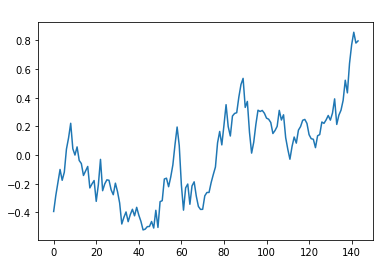

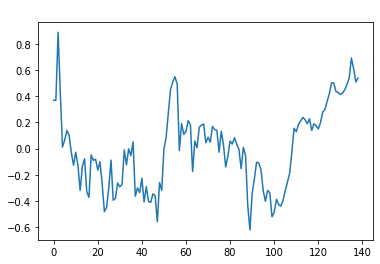

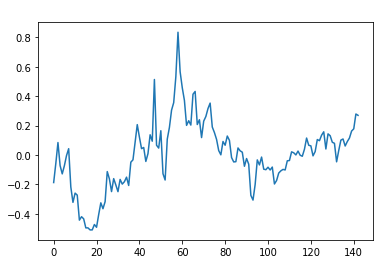

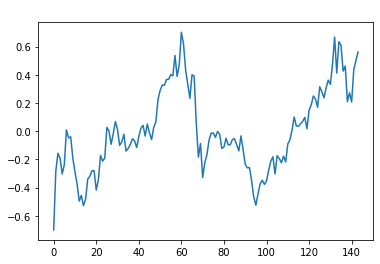

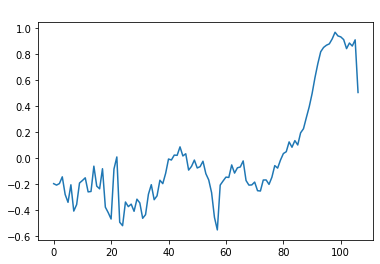

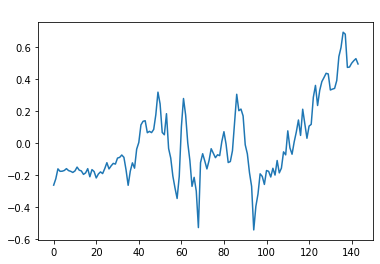

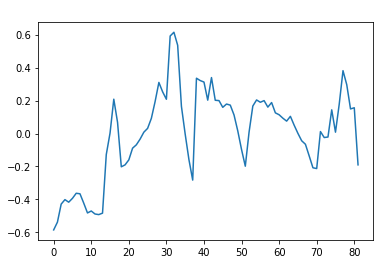

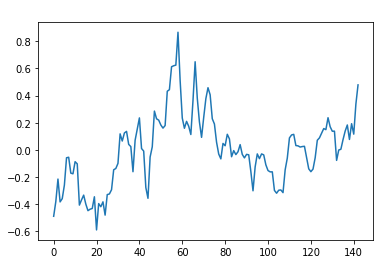

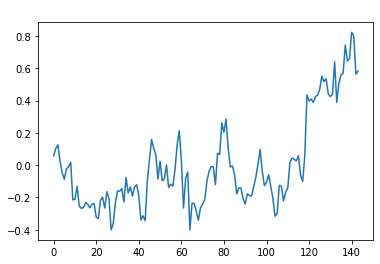

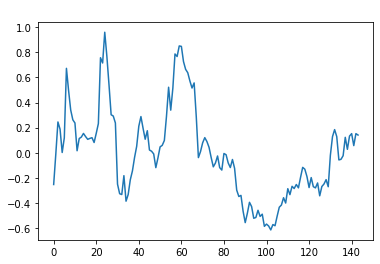

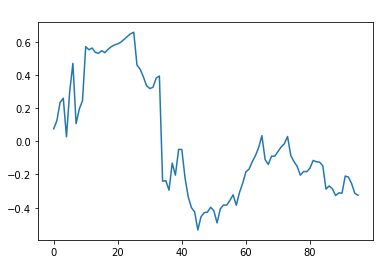

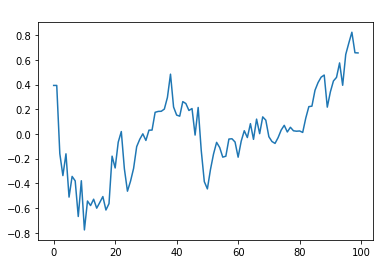

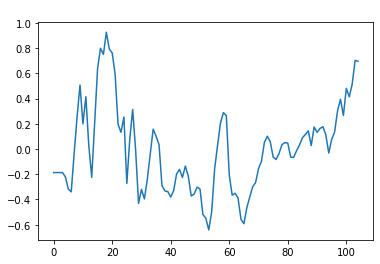

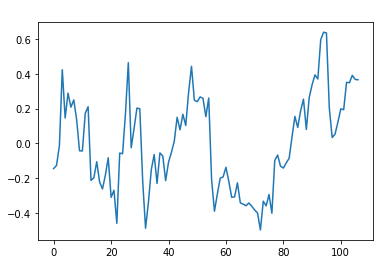

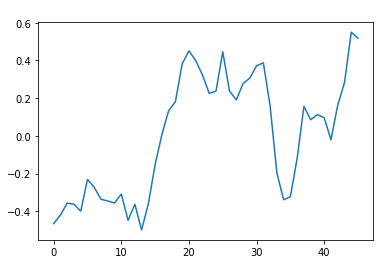

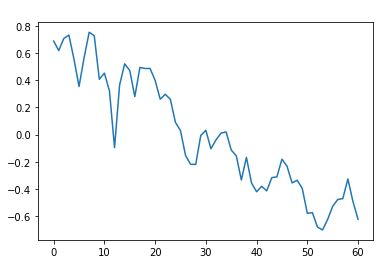

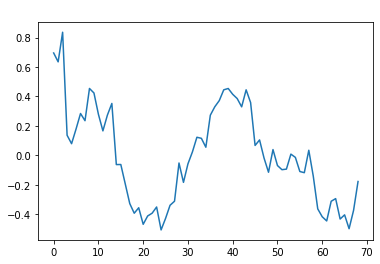

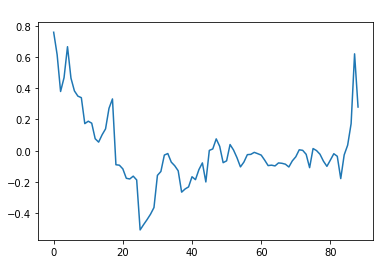

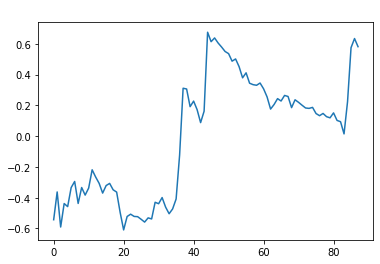

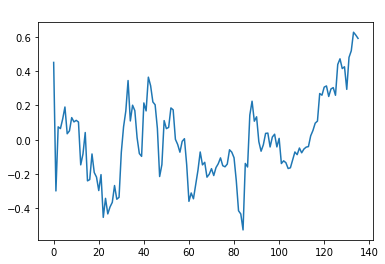

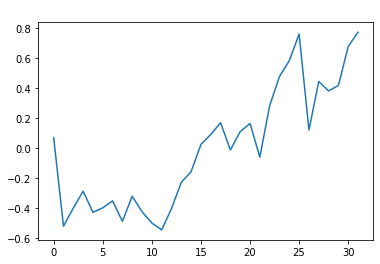

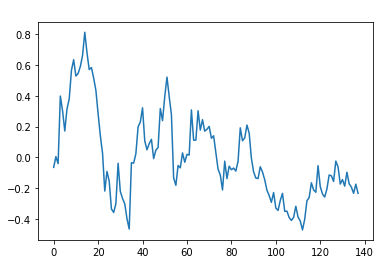

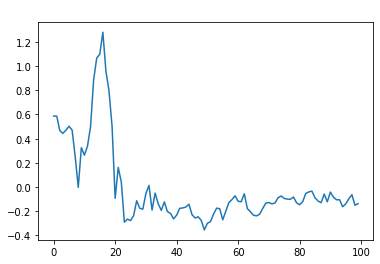

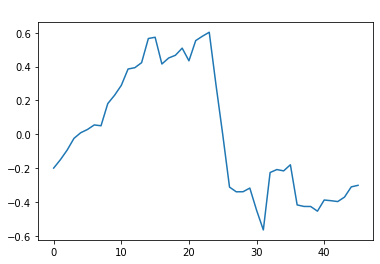

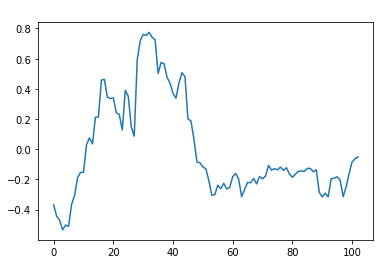

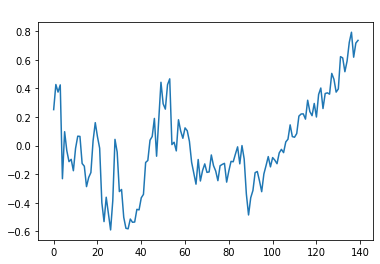

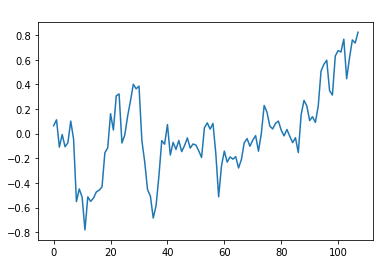

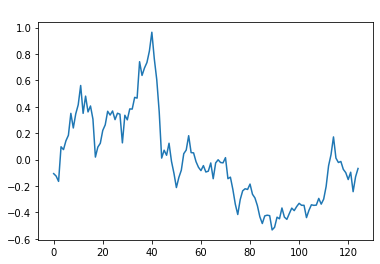

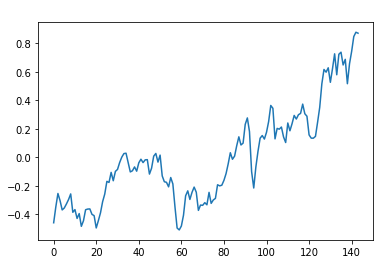

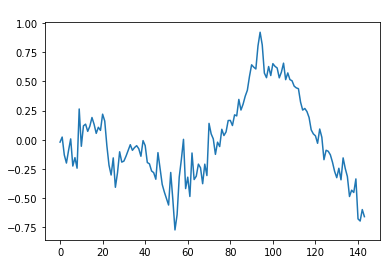

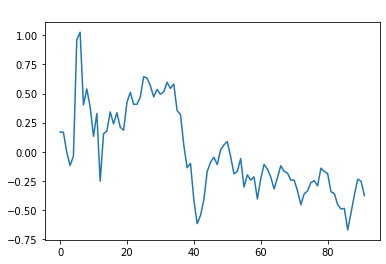

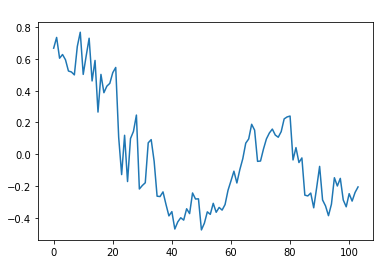

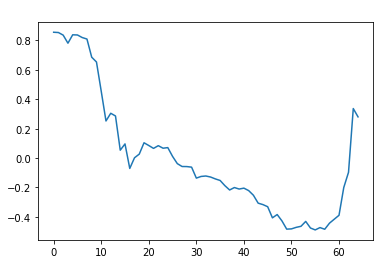

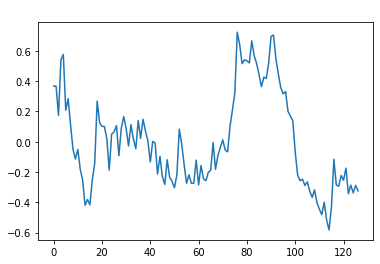

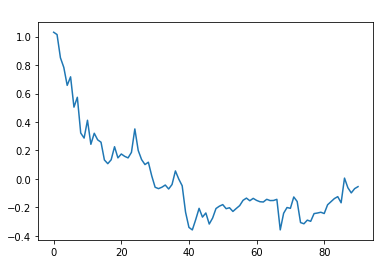

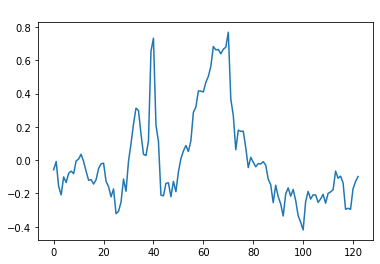

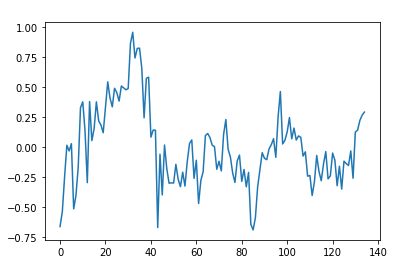

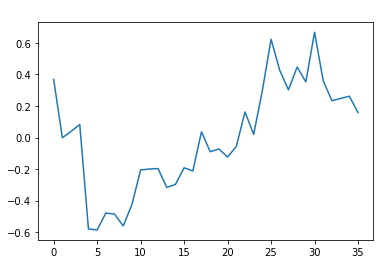

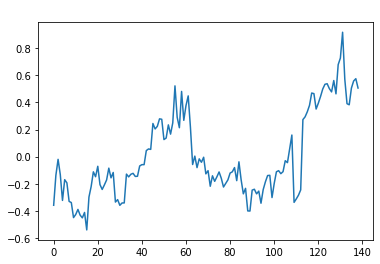

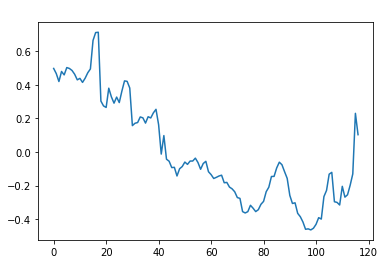

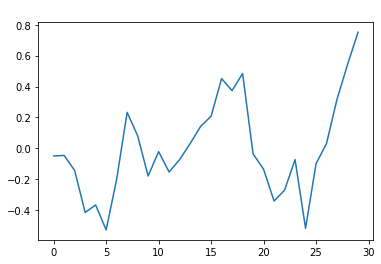

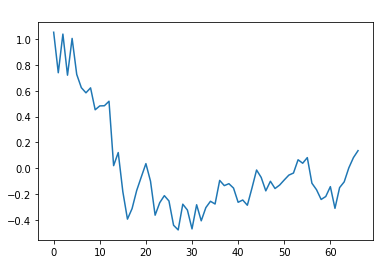

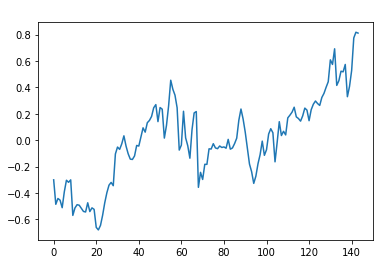

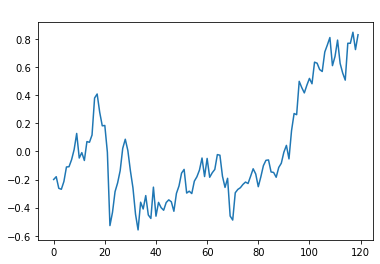

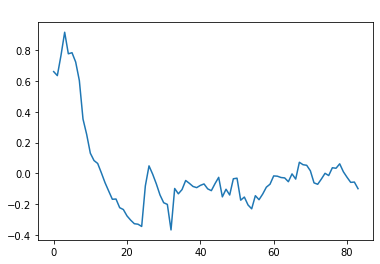

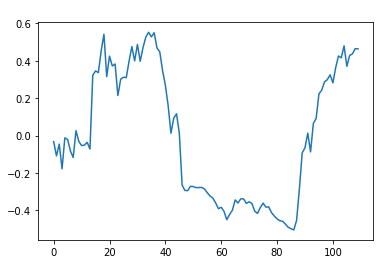

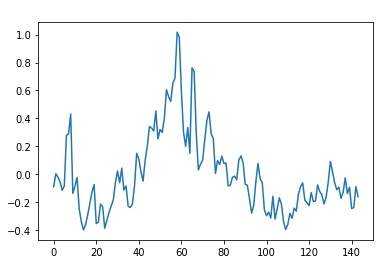

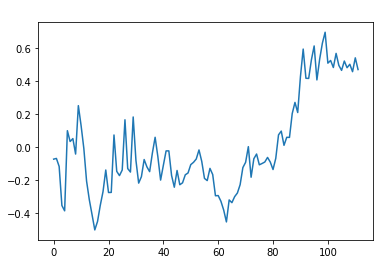

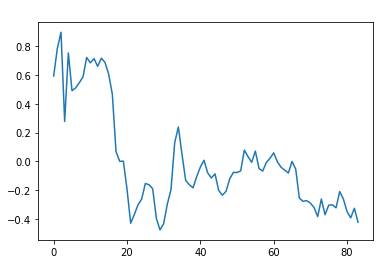

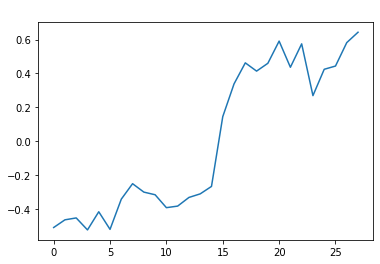

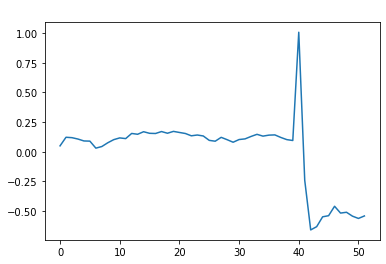

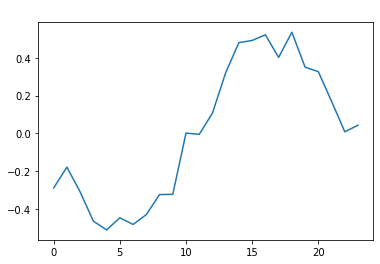

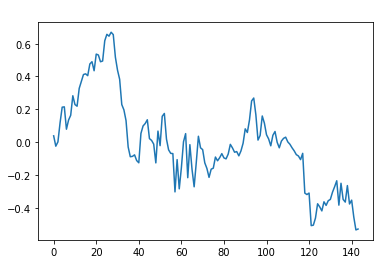

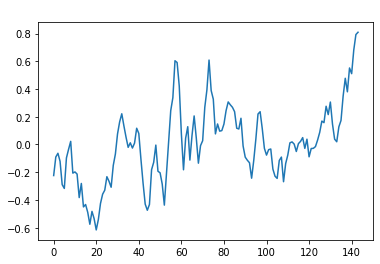

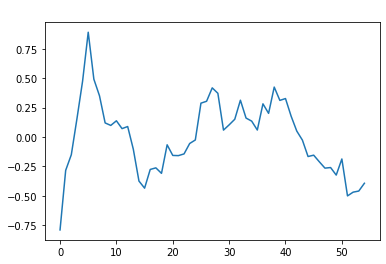

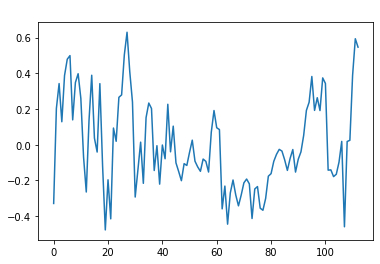

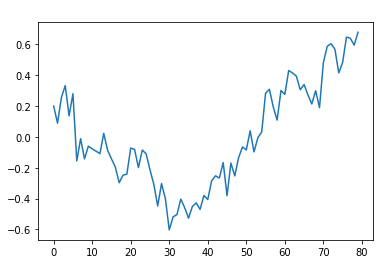

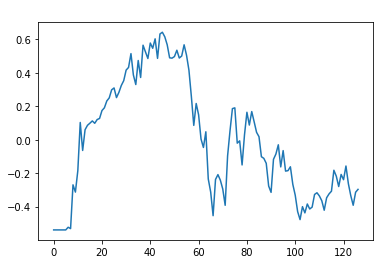

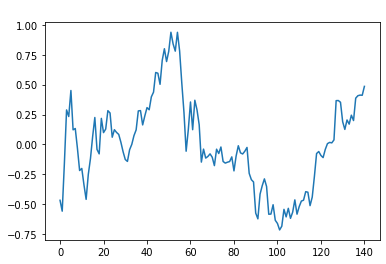

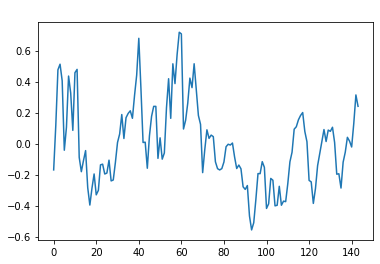

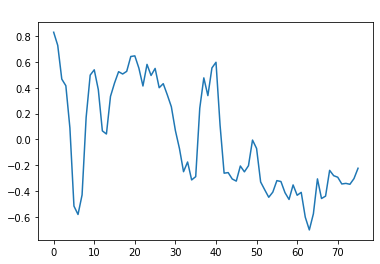

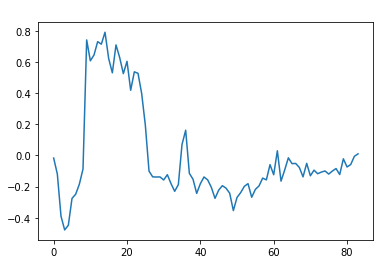

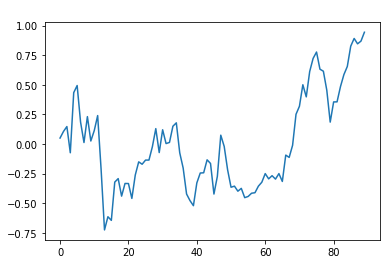

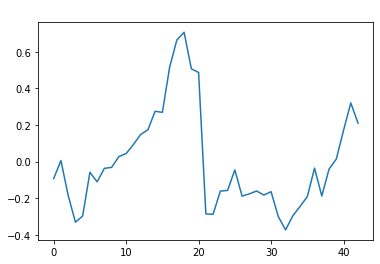

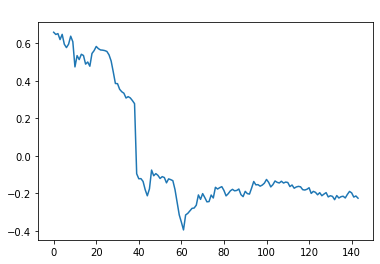

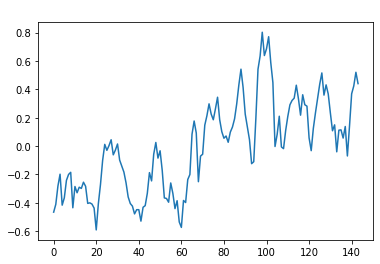

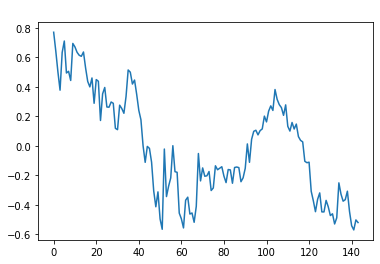

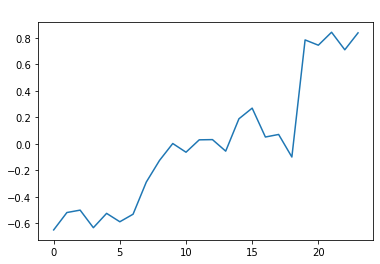

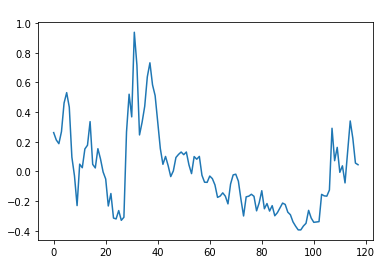

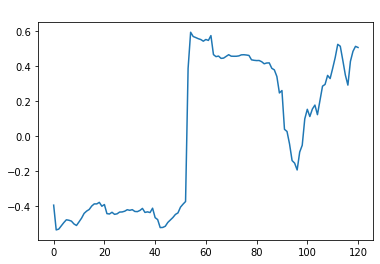

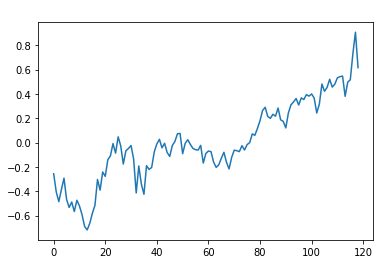

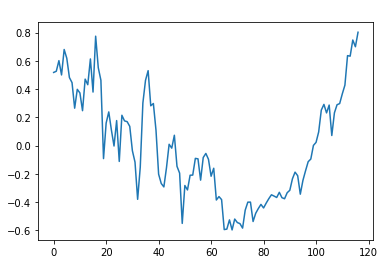

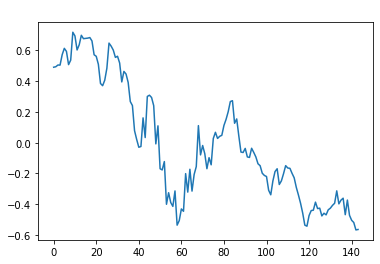

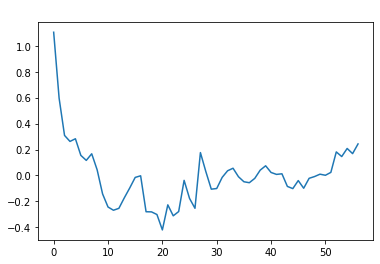

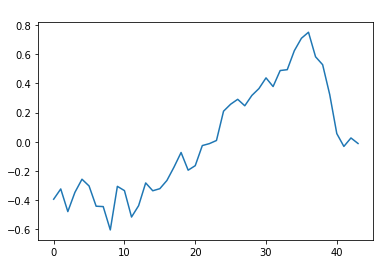

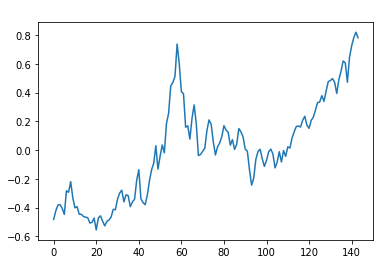

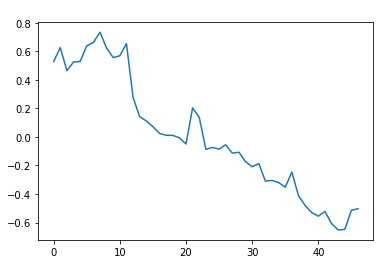

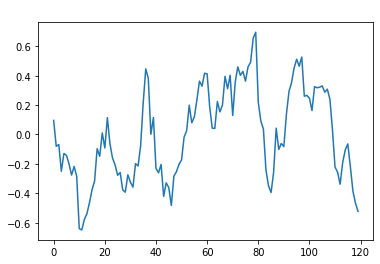

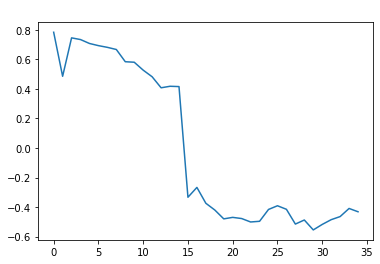

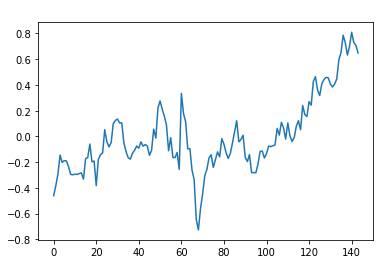

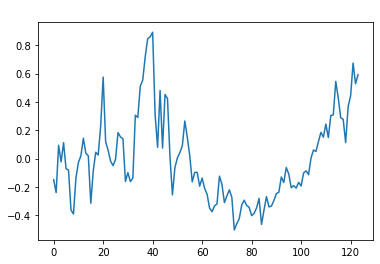

In [8]:
for i in range(len(all_data)):
    k = list(all_data.keys())
    plt.figure(i)
    plt.plot([x for x in range(len(all_data[k[i]]))], all_data[k[i]]["Z"])
    plt.title(k[i],c="white",loc="left")

/Users/austinriis-due/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


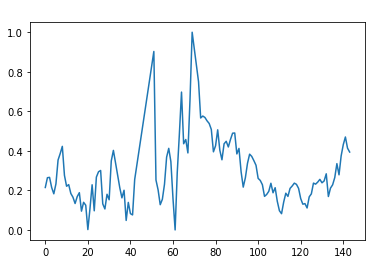

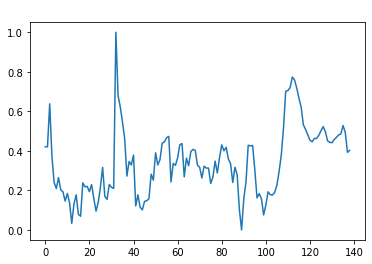

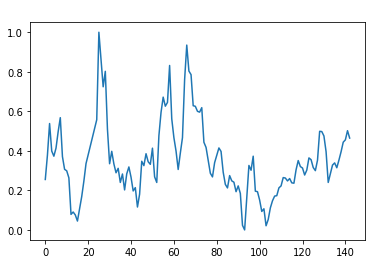

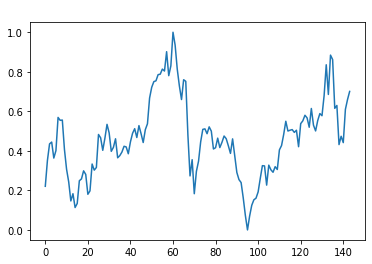

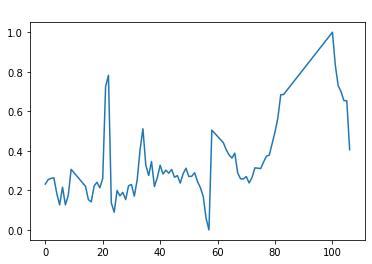

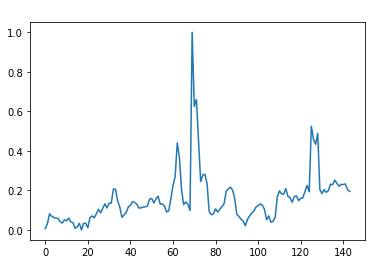

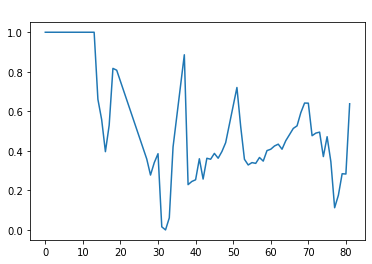

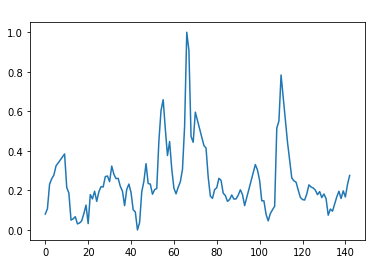

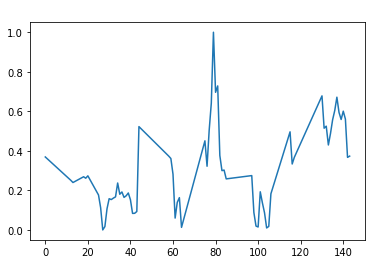

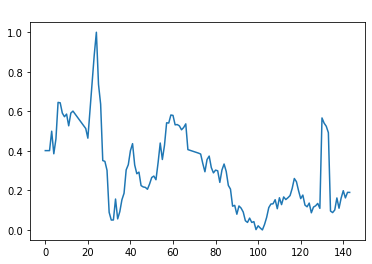

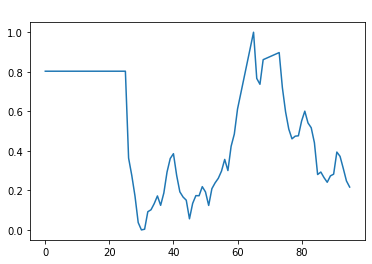

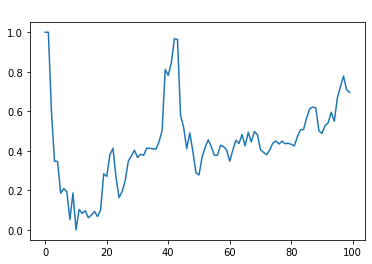

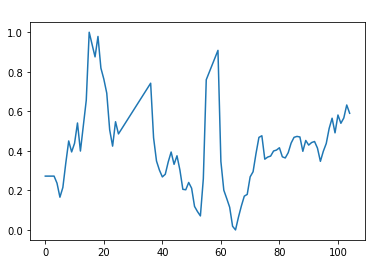

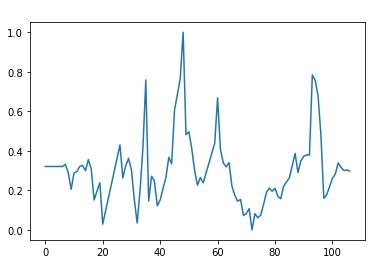

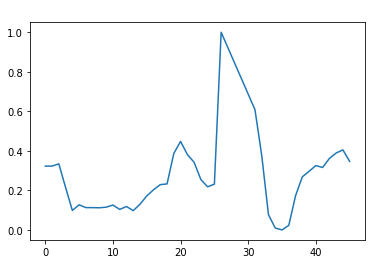

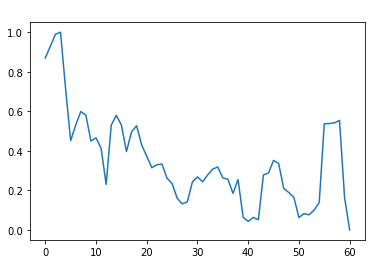

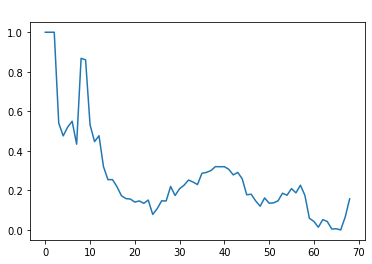

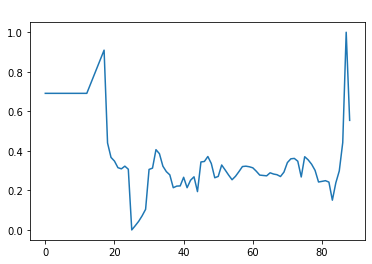

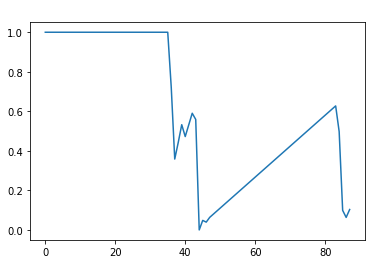

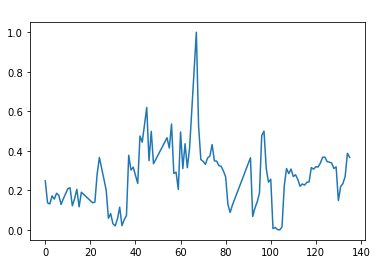

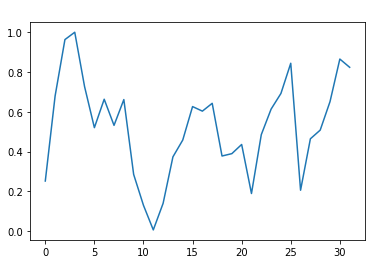

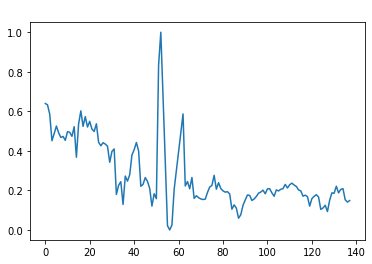

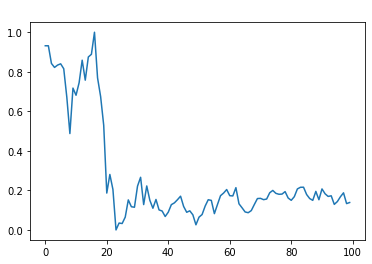

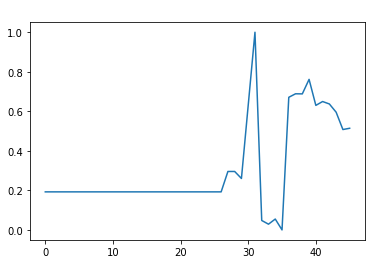

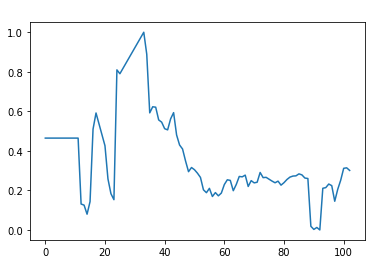

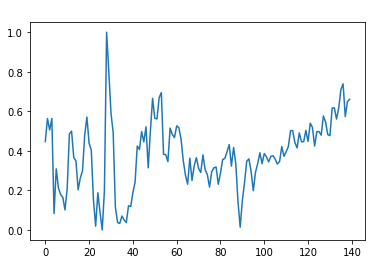

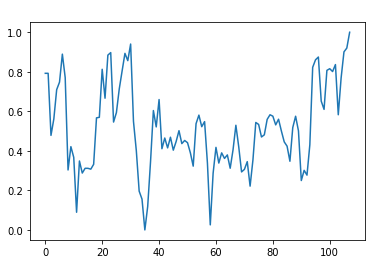

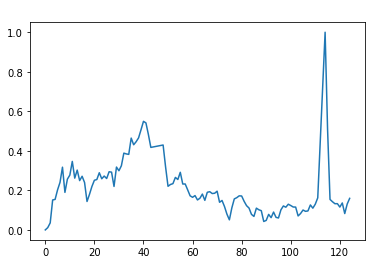

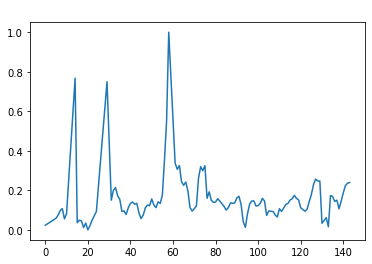

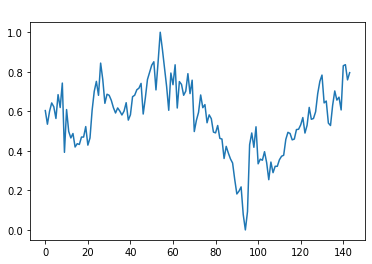

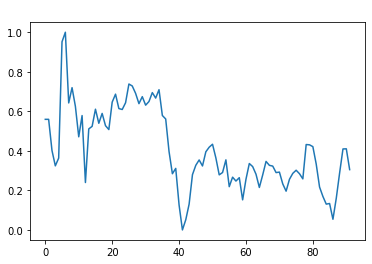

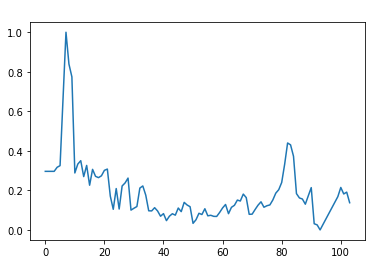

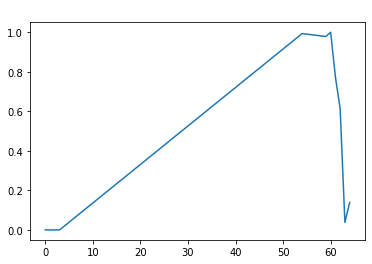

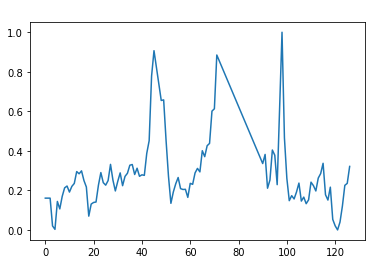

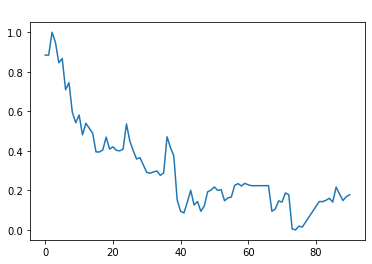

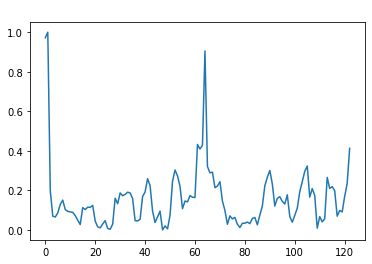

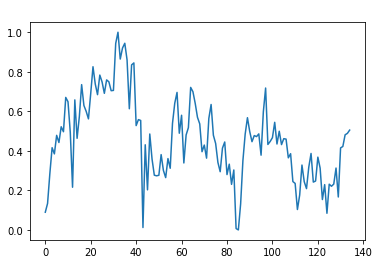

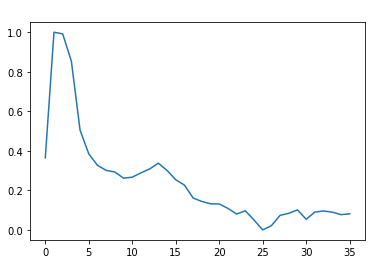

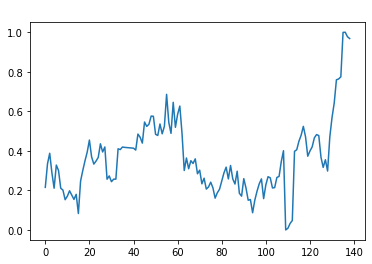

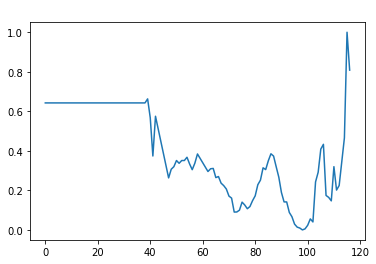

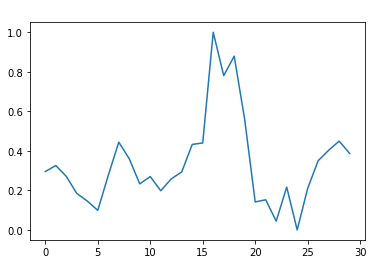

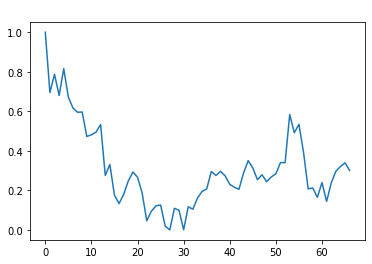

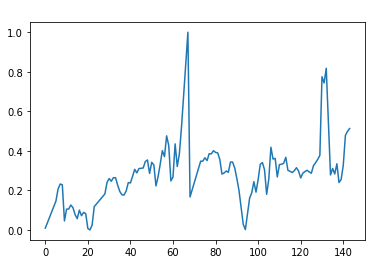

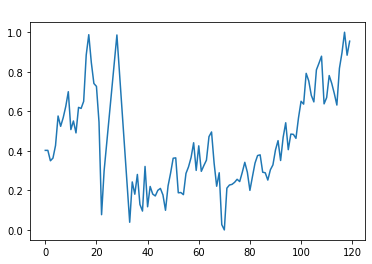

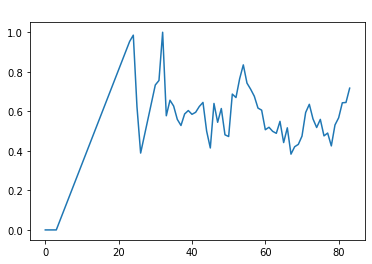

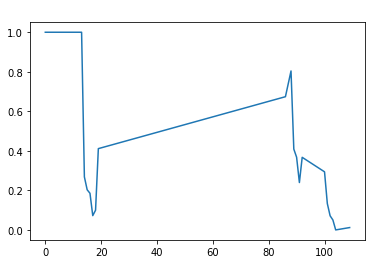

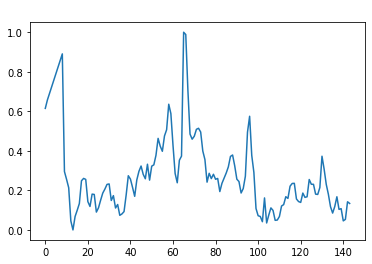

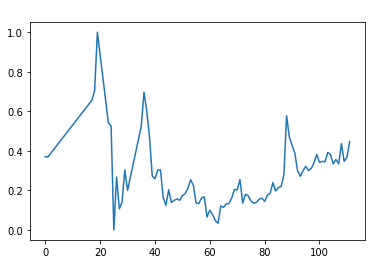

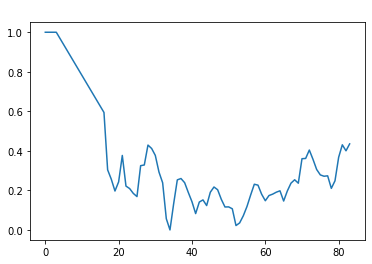

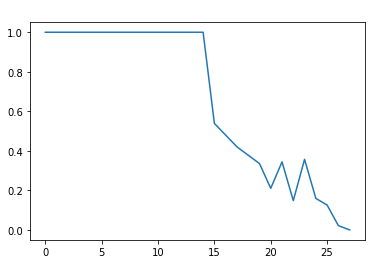

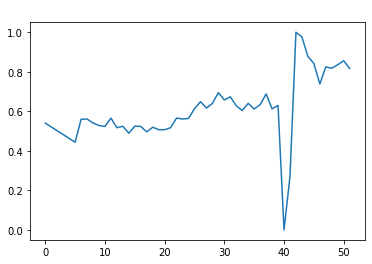

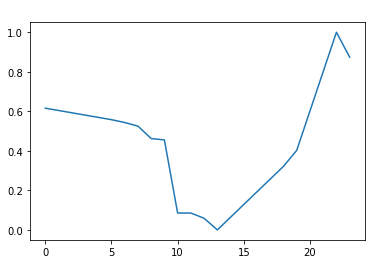

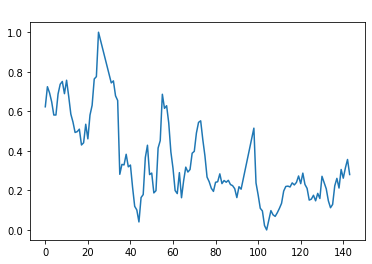

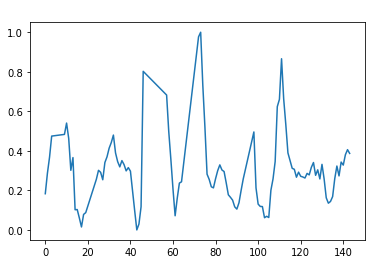

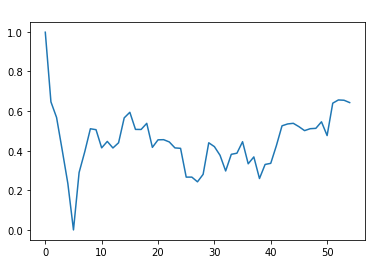

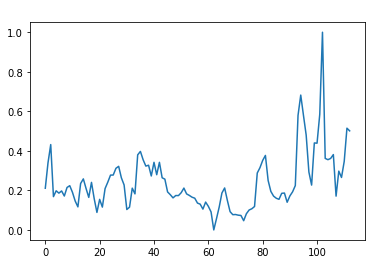

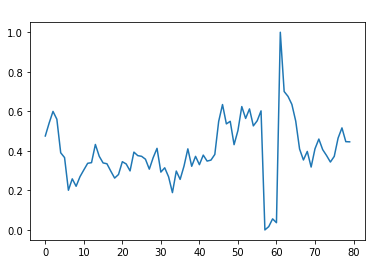

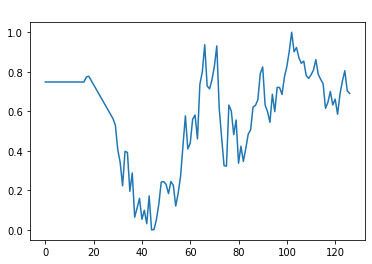

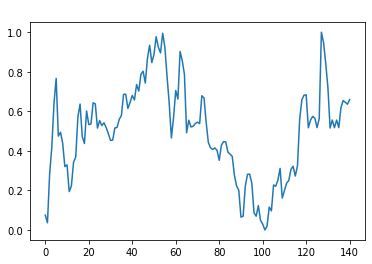

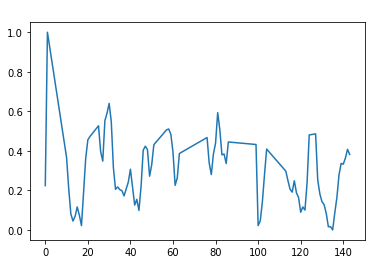

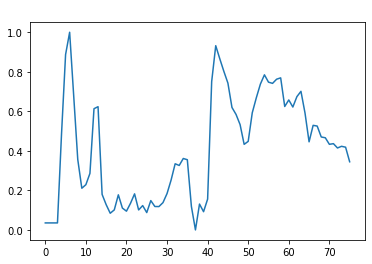

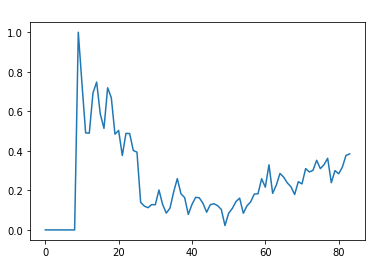

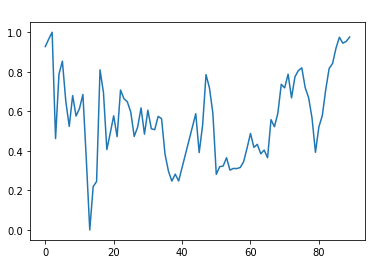

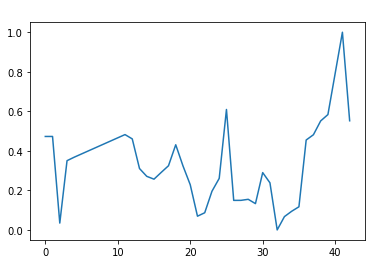

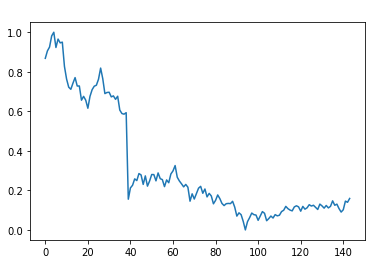

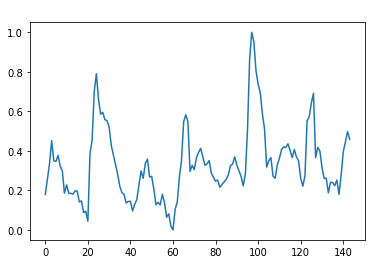

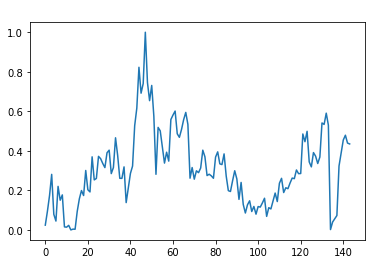

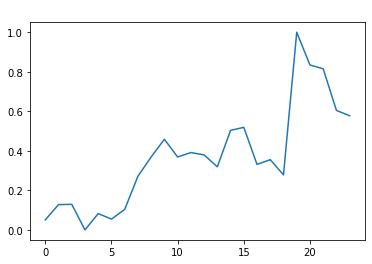

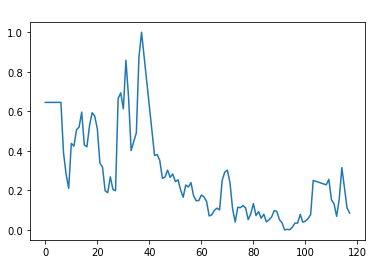

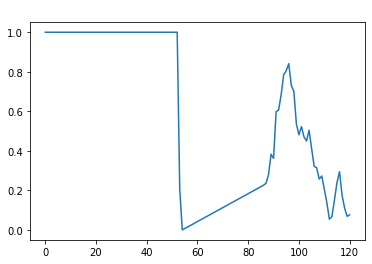

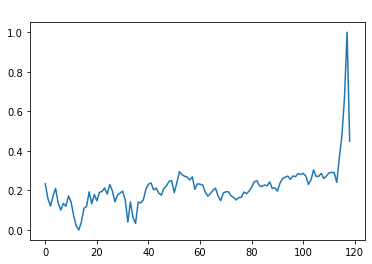

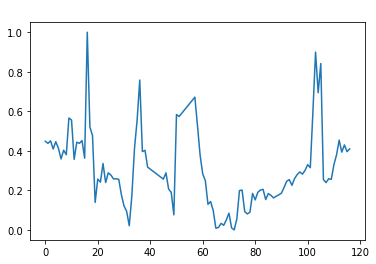

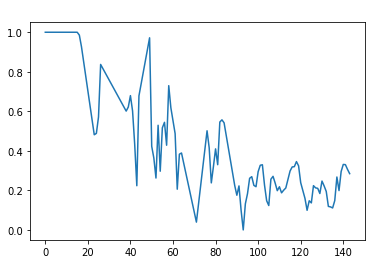

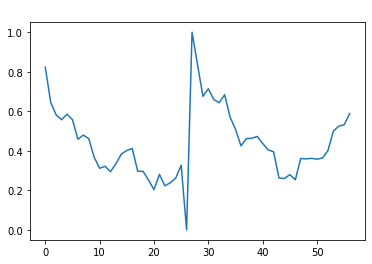

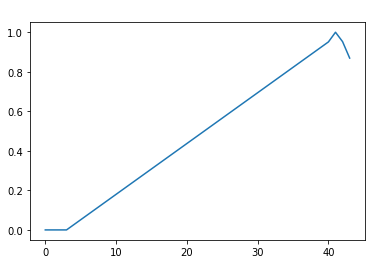

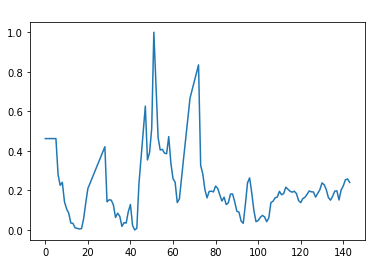

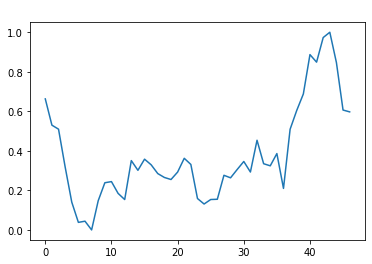

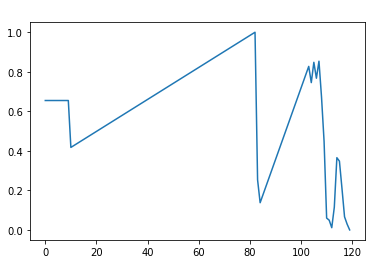

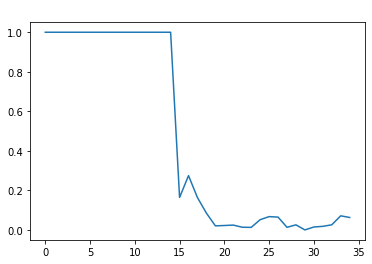

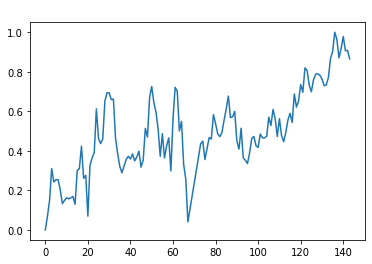

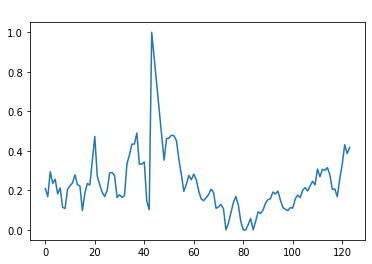

In [9]:
for i in range(len(all_data)):
    k = list(all_data.keys())
    plt.figure(i)
    plt.plot([x for x in range(len(all_data[k[i]]))], all_data[k[i]]["PeRatio"])
    plt.title(k[i],c="white",loc="left")

/Users/austinriis-due/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


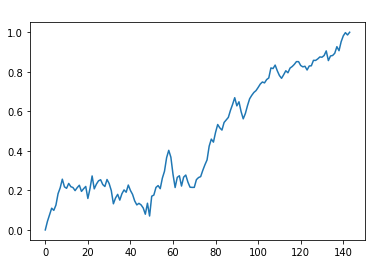

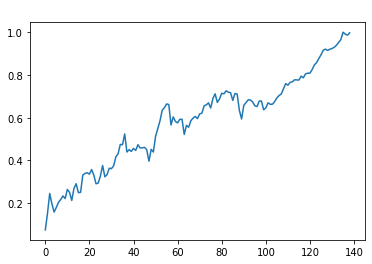

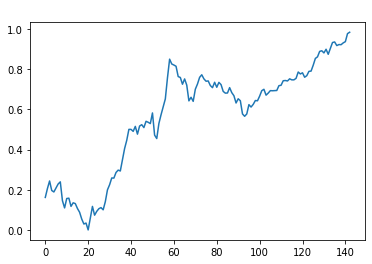

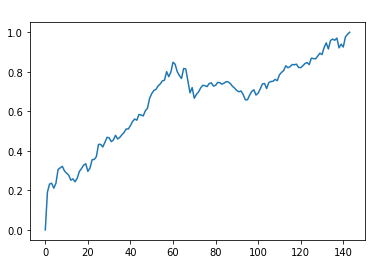

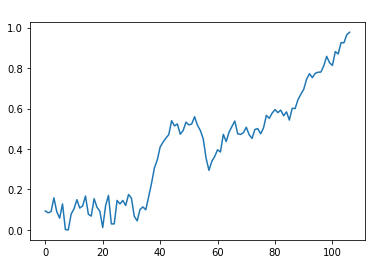

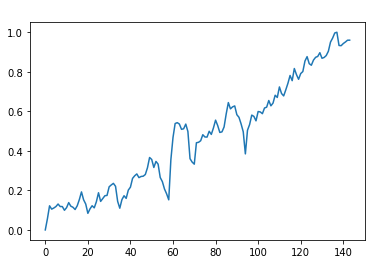

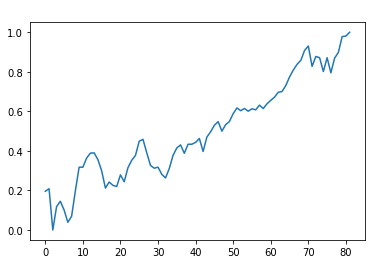

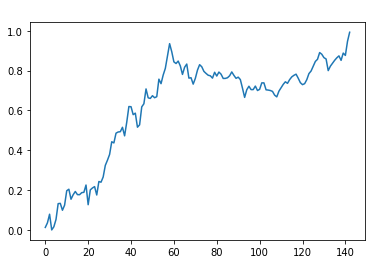

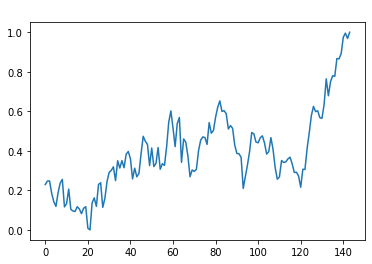

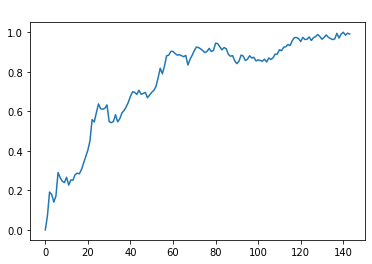

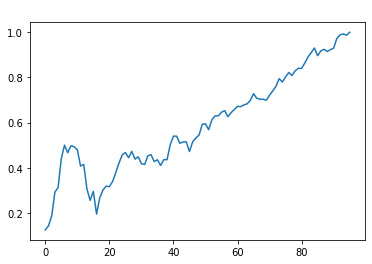

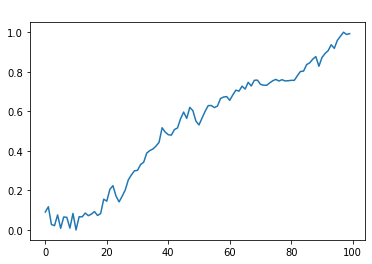

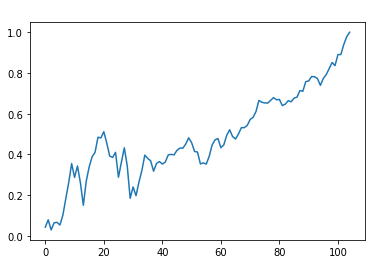

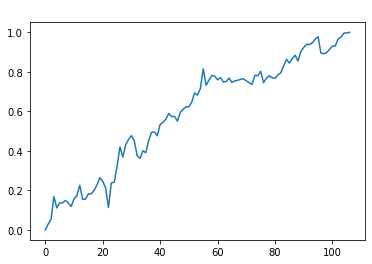

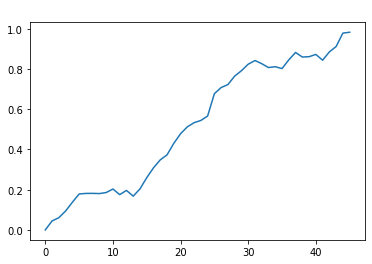

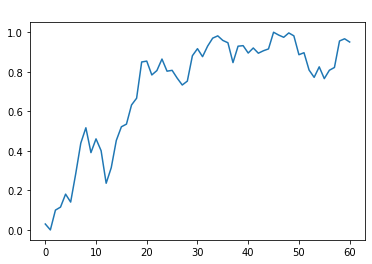

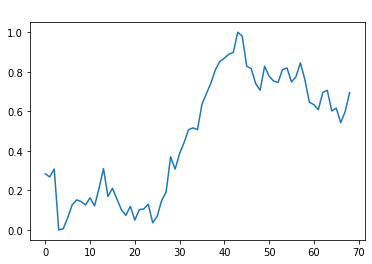

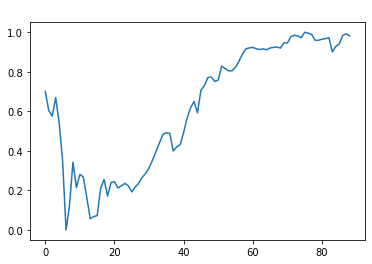

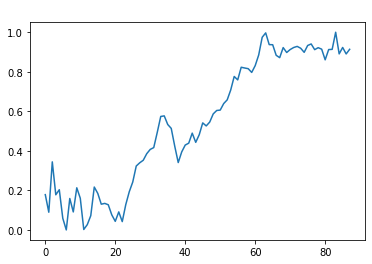

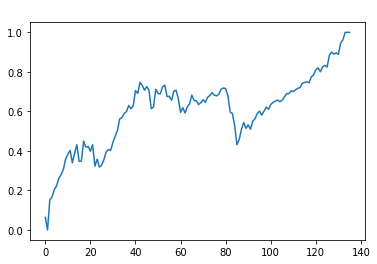

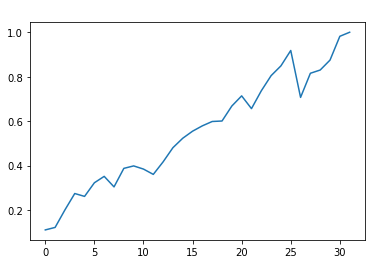

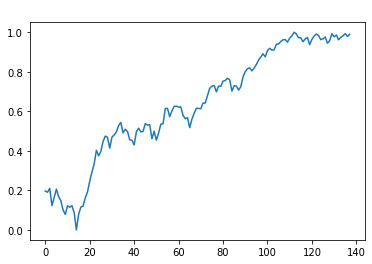

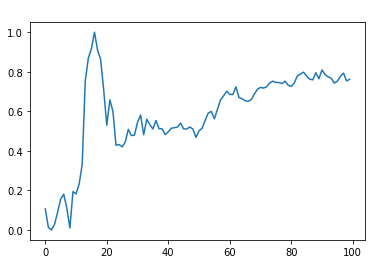

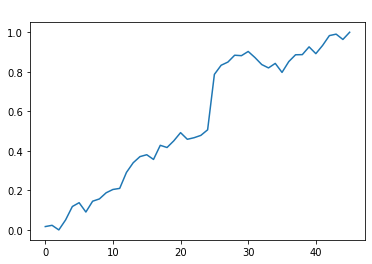

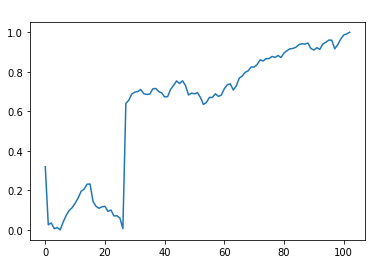

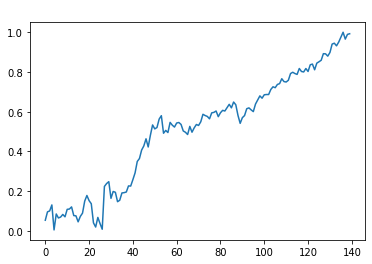

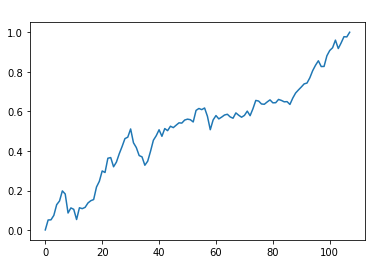

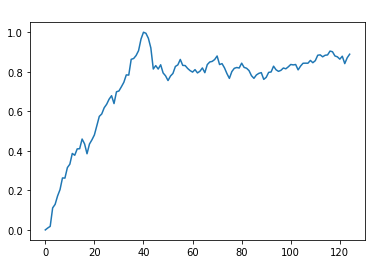

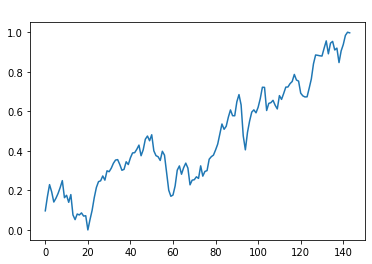

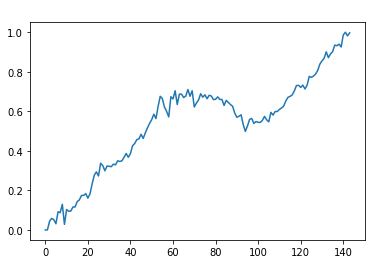

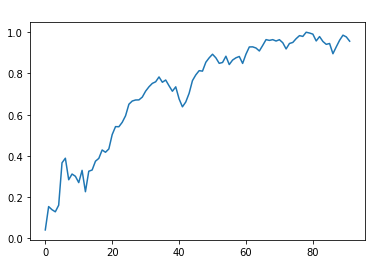

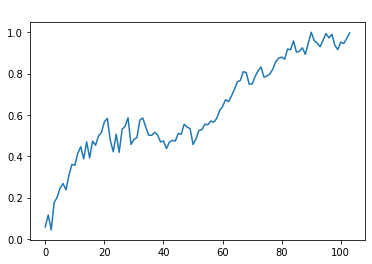

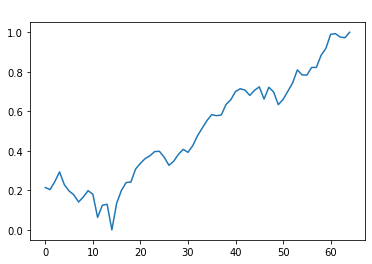

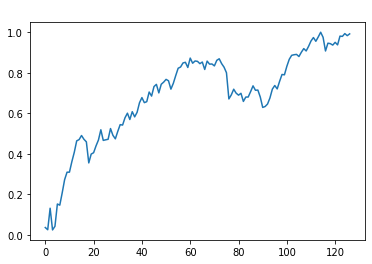

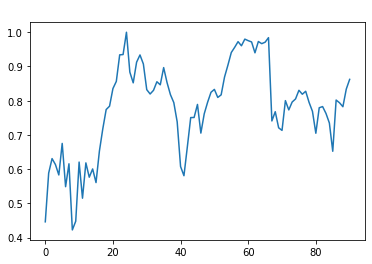

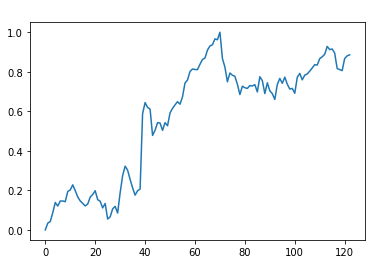

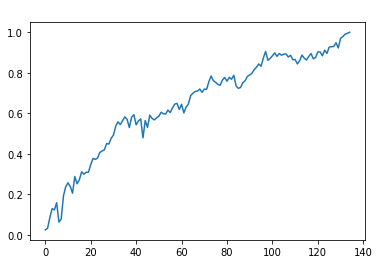

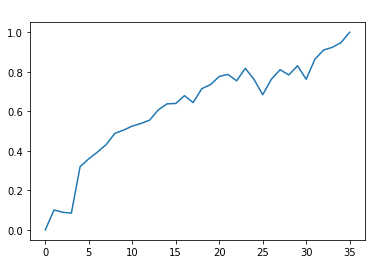

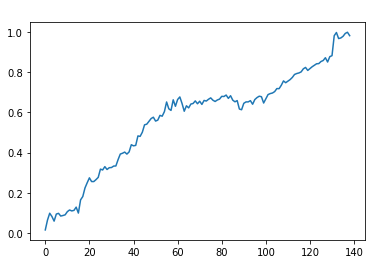

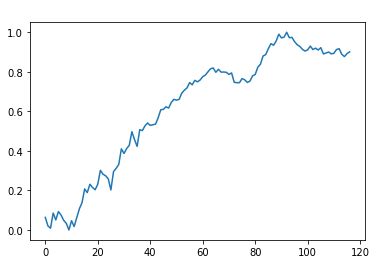

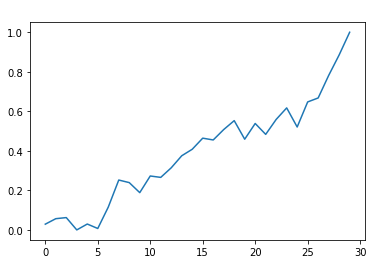

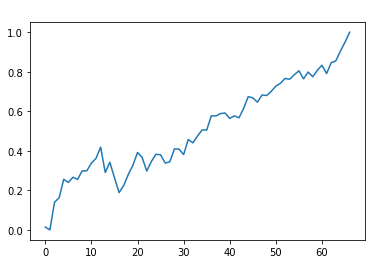

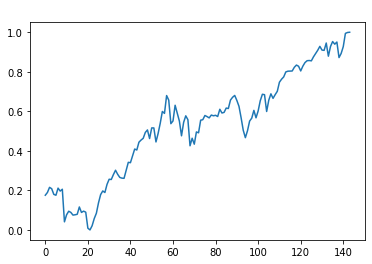

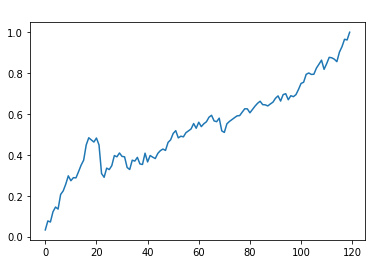

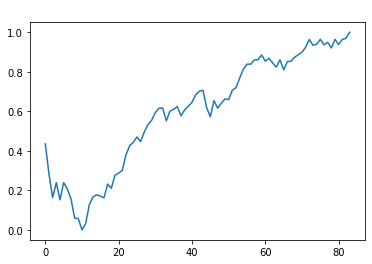

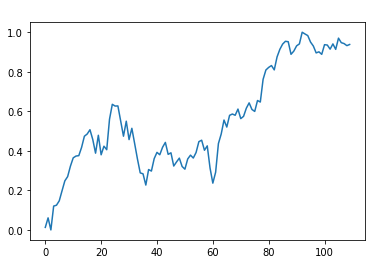

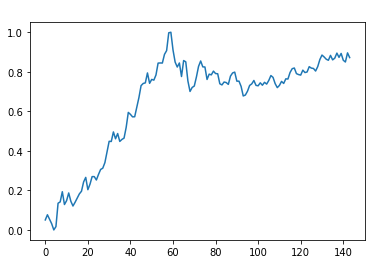

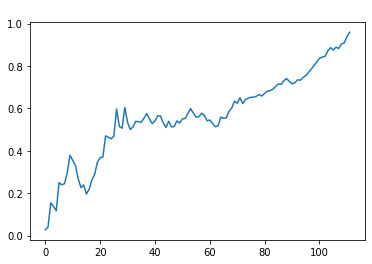

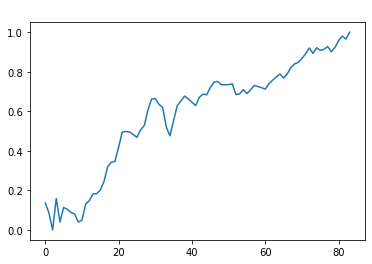

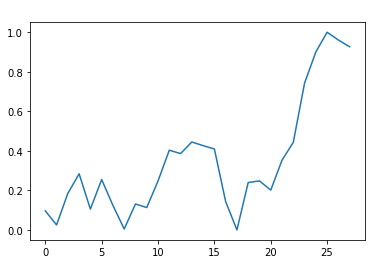

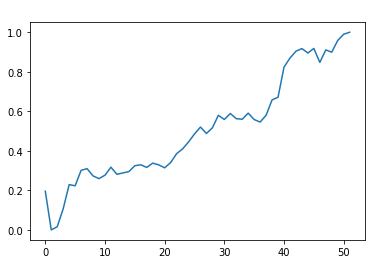

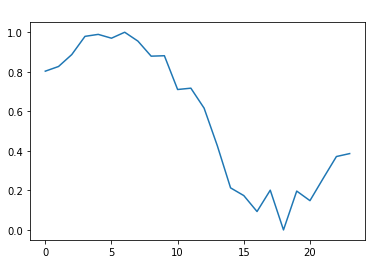

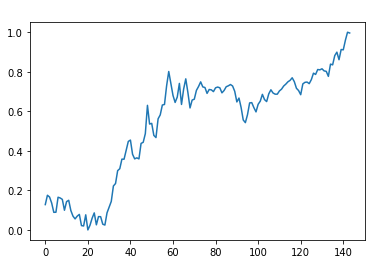

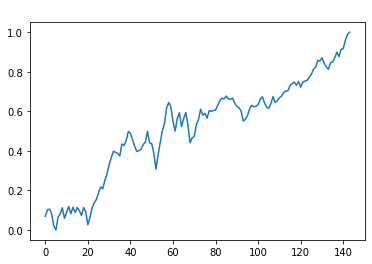

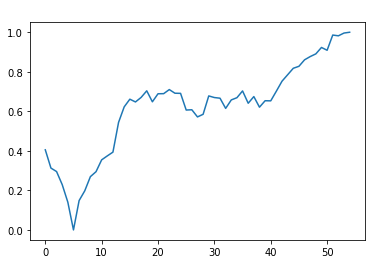

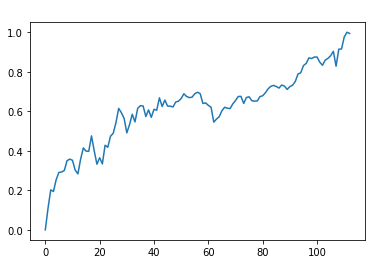

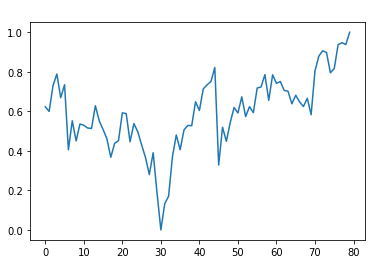

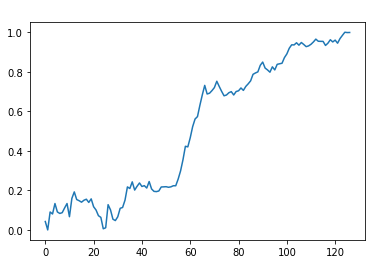

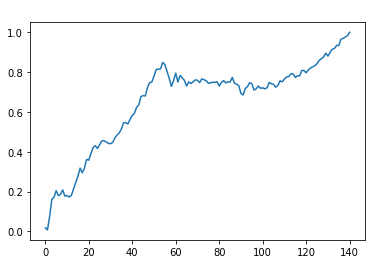

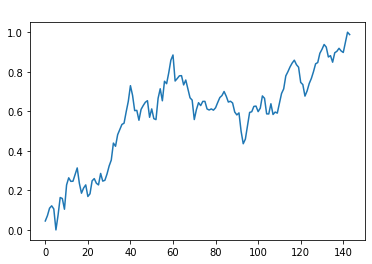

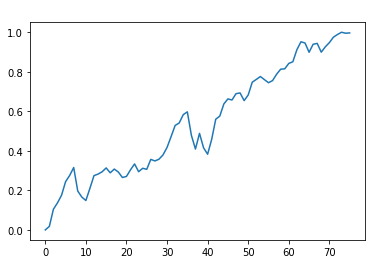

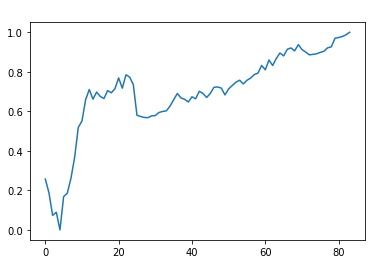

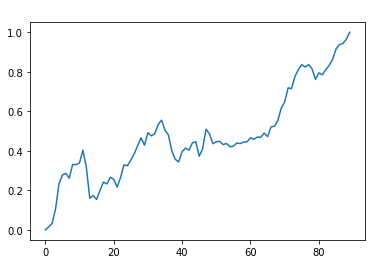

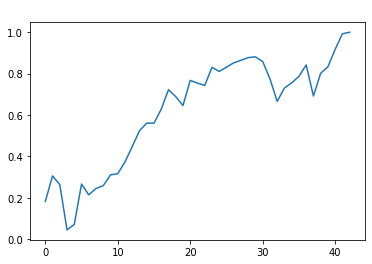

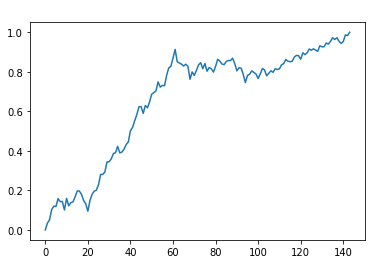

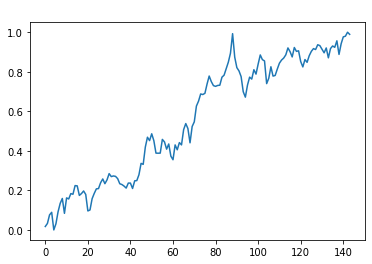

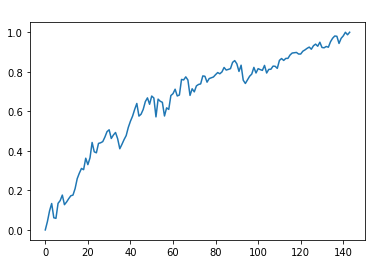

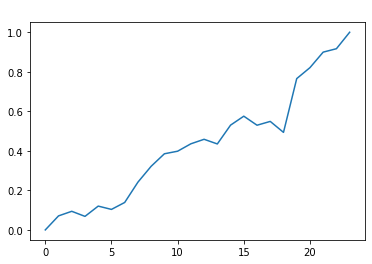

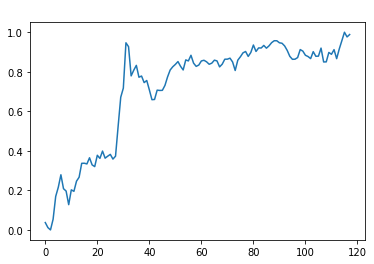

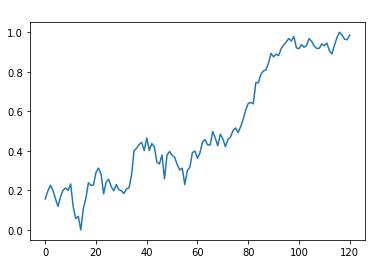

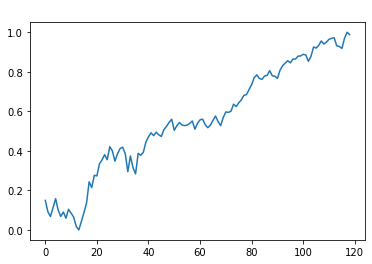

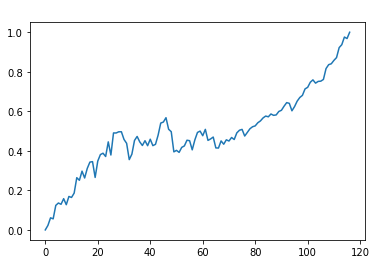

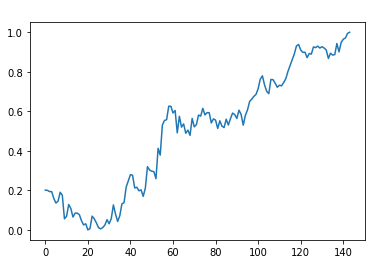

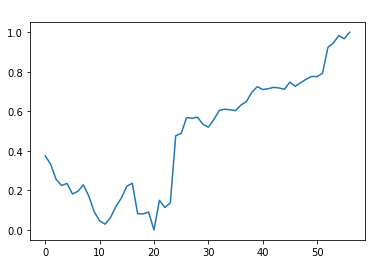

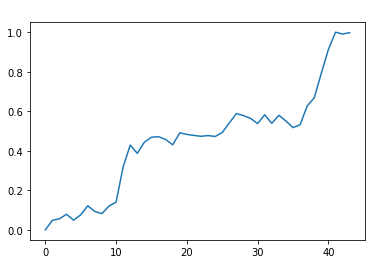

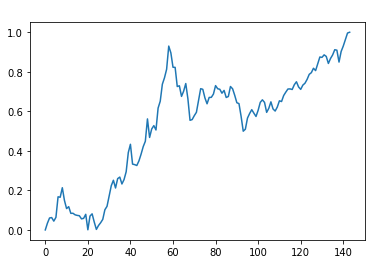

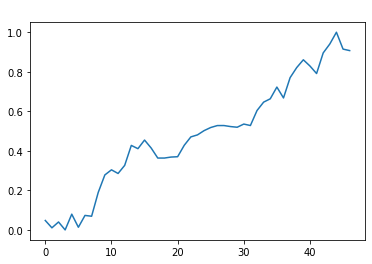

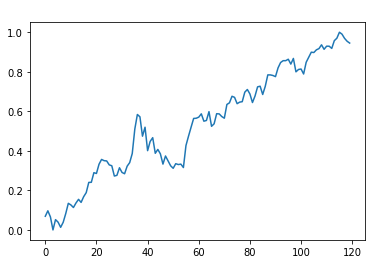

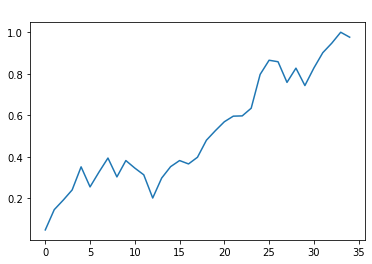

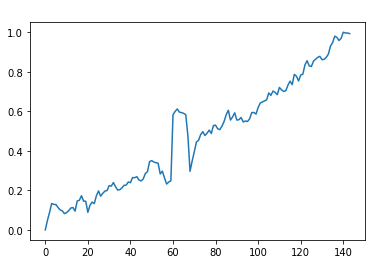

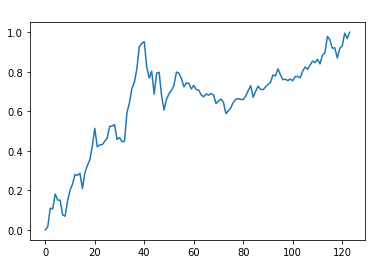

In [10]:
for i in range(len(all_data)):
    k = list(all_data.keys())
    plt.figure(i)
    plt.plot([x for x in range(len(all_data[k[i]]))], all_data[k[i]]["MarketCap"])
    plt.title(k[i],c="white",loc="left")

Proportion Down AAPL 0.49
Proportion Down ADBE 0.41
Proportion Down ADI 0.48
Proportion Down ADP 0.44
Proportion Down ADSK 0.48
Proportion Down AEP 0.31
Proportion Down ALGN 0.44
Proportion Down AMAT 0.46
Proportion Down AMD 0.53
Proportion Down AMGN 0.44
Proportion Down AMZN 0.4
Proportion Down ANSS 0.45
Proportion Down ASML 0.44
Proportion Down ATVI 0.39
Proportion Down AVGO 0.5
Proportion Down BIDU 0.46
Proportion Down BIIB 0.48
Proportion Down BKNG 0.53
Proportion Down BMRN 0.43
Proportion Down CDNS 0.48
Proportion Down CDW 0.31


/Users/austinriis-due/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


Proportion Down CERN 0.41
Proportion Down CHKP 0.47
Proportion Down CHTR 0.37
Proportion Down CMCSA 0.41
Proportion Down COST 0.41
Proportion Down CPRT 0.45
Proportion Down CSCO 0.38
Proportion Down CSX 0.43
Proportion Down CTAS 0.4
Proportion Down CTSH 0.45
Proportion Down DLTR 0.41
Proportion Down DXCM 0.43
Proportion Down EA 0.4
Proportion Down EBAY 0.49
Proportion Down EXC 0.31
Proportion Down FAST 0.47
Proportion Down FB 0.42
Proportion Down FISV 0.37
Proportion Down GILD 0.47
Proportion Down GOOG 0.5
Proportion Down GOOGL 0.4
Proportion Down HON 0.42
Proportion Down IDXX 0.43
Proportion Down ILMN 0.36
Proportion Down INCY 0.5
Proportion Down INTC 0.48
Proportion Down INTU 0.48
Proportion Down ISRG 0.4
Proportion Down JD 0.43
Proportion Down KDP 0.37
Proportion Down KHC 0.54
Proportion Down KLAC 0.45
Proportion Down LRCX 0.52
Proportion Down LULU 0.49
Proportion Down MCHP 0.44
Proportion Down MDLZ 0.55
Proportion Down MNST 0.49
Proportion Down MSFT 0.36
Proportion Down MU 0.46
Pro

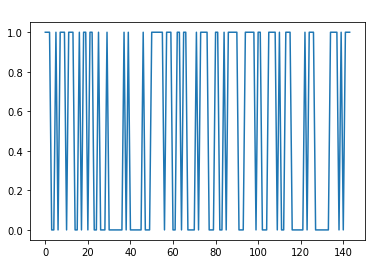

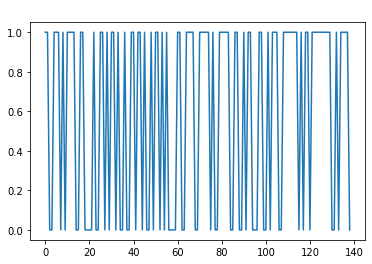

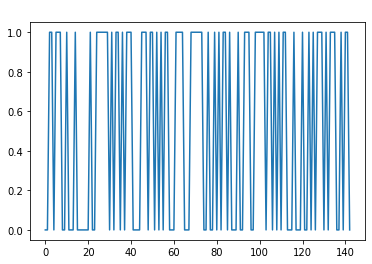

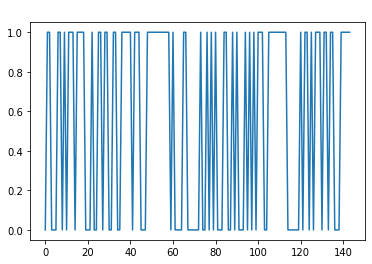

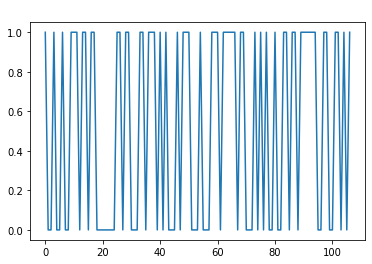

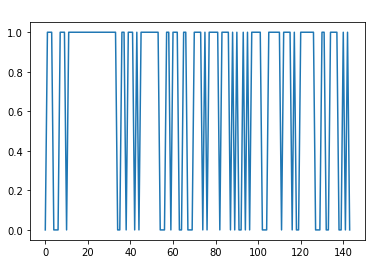

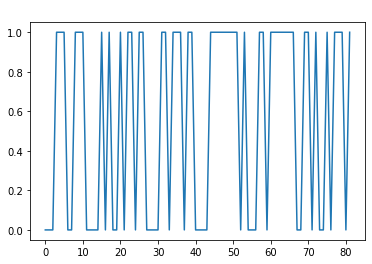

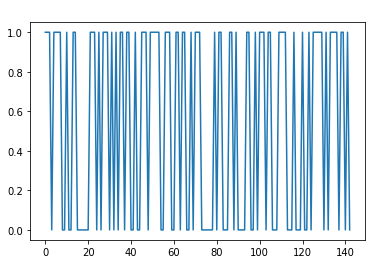

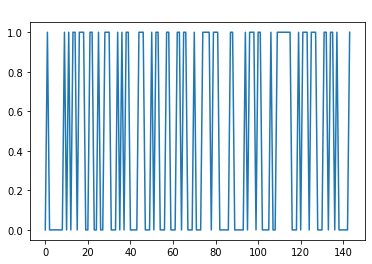

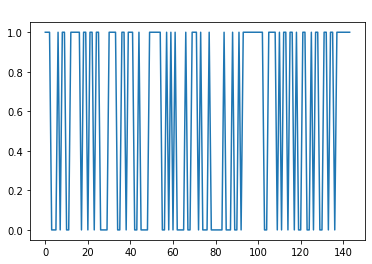

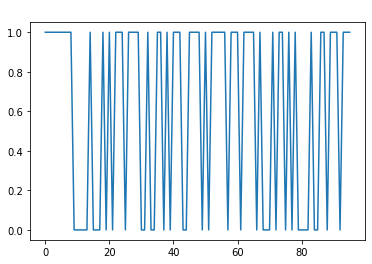

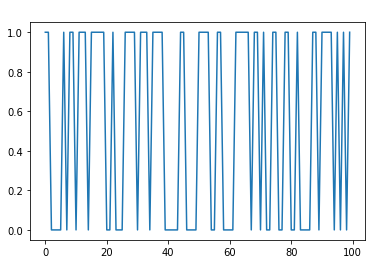

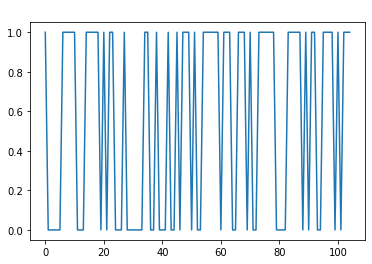

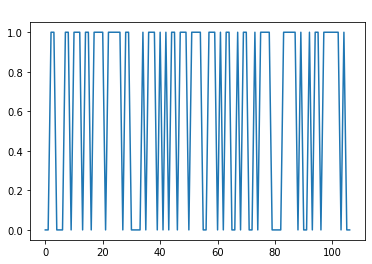

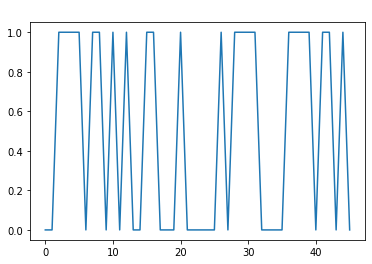

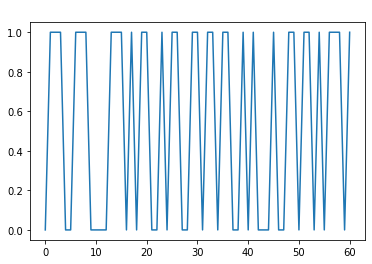

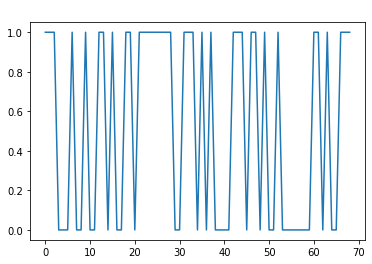

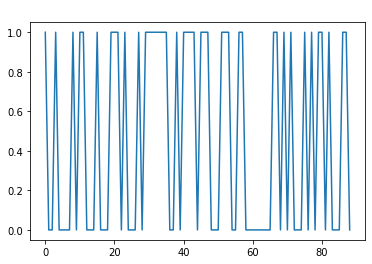

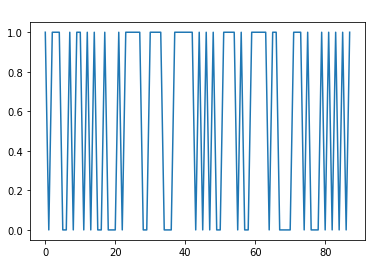

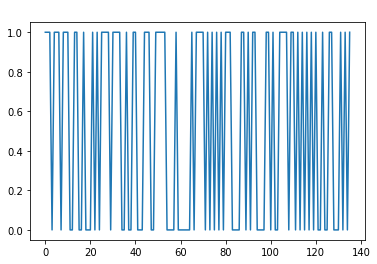

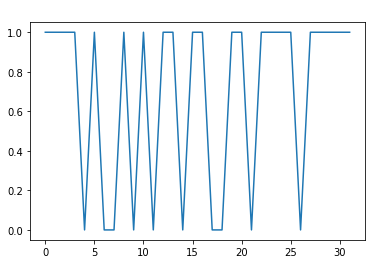

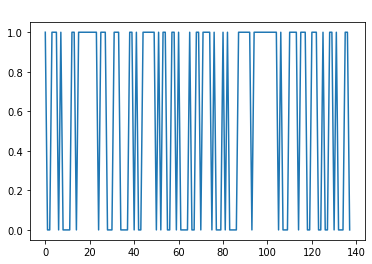

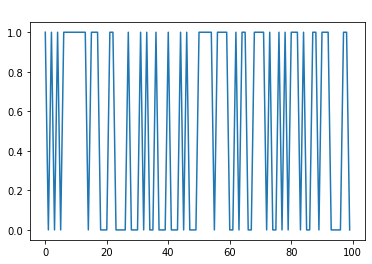

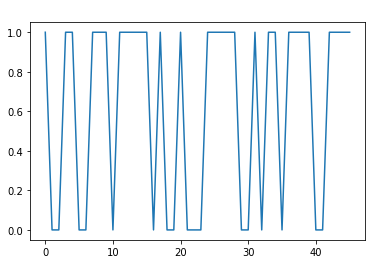

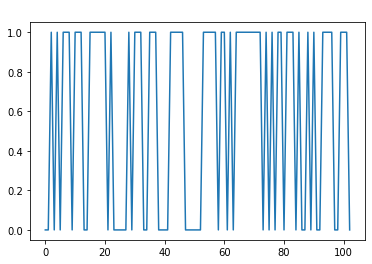

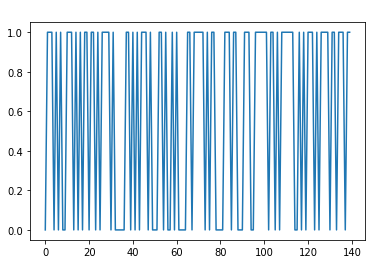

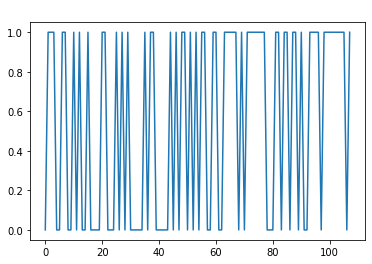

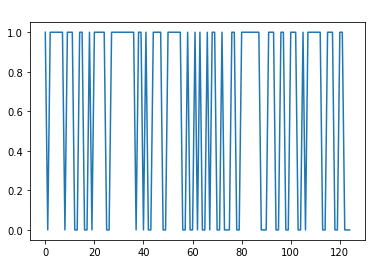

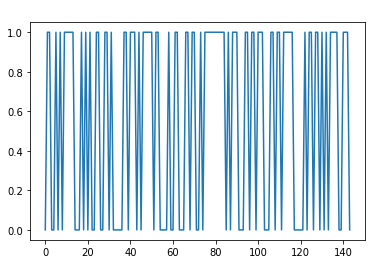

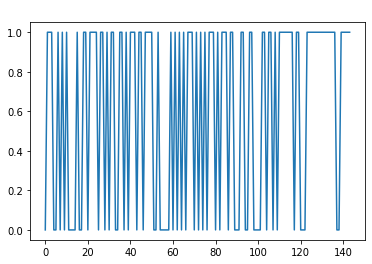

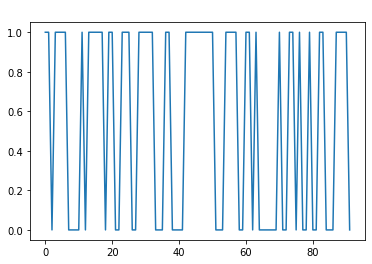

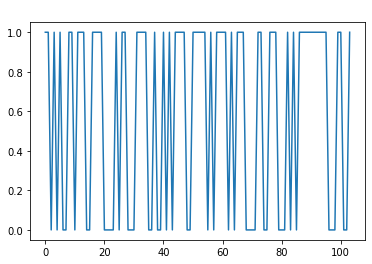

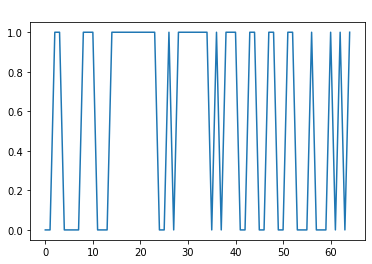

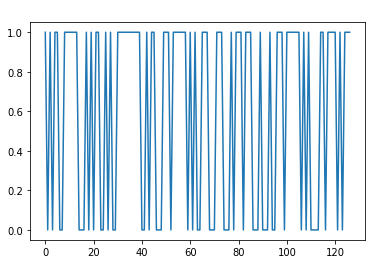

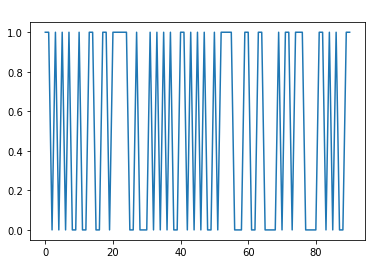

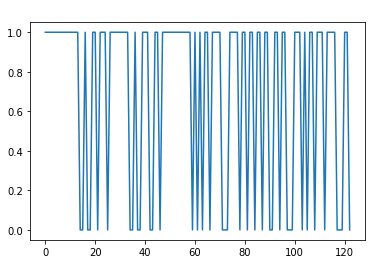

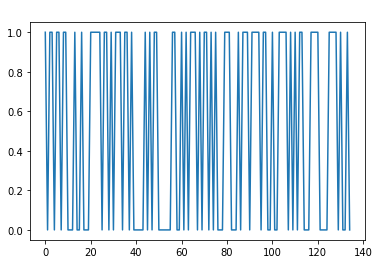

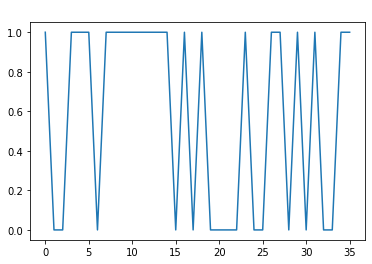

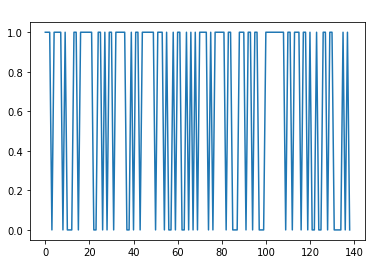

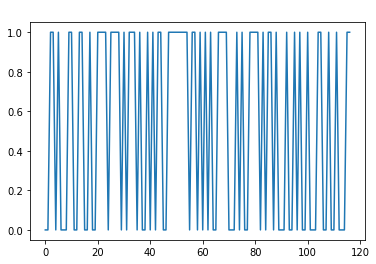

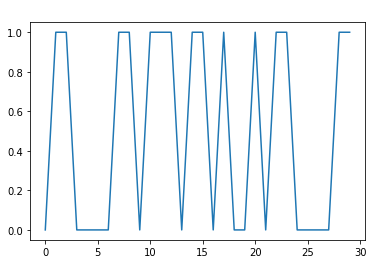

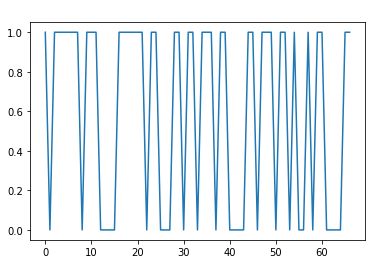

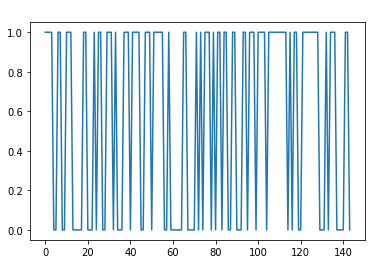

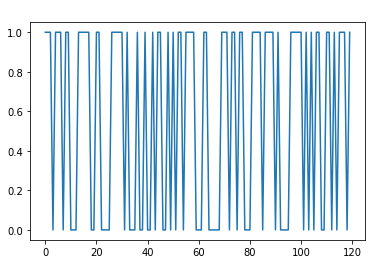

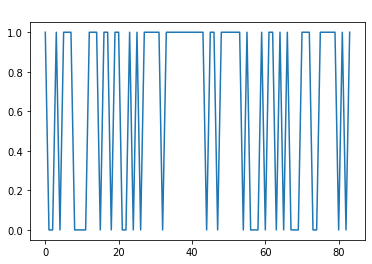

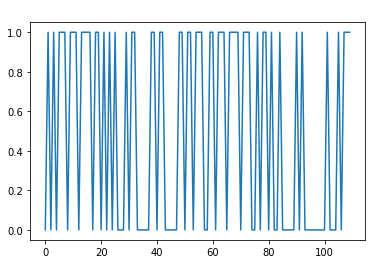

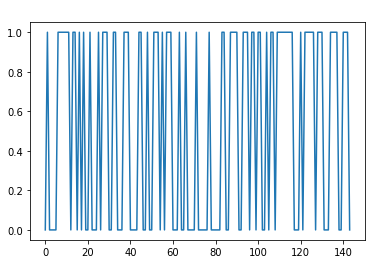

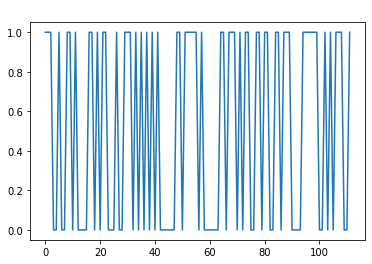

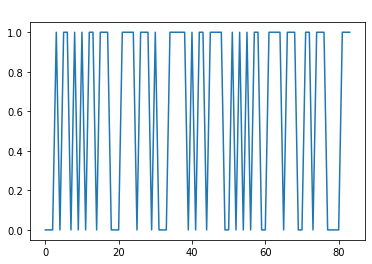

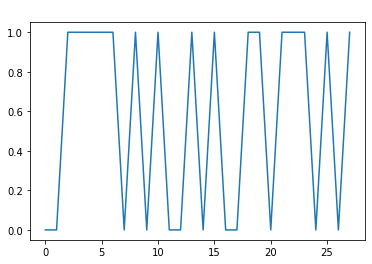

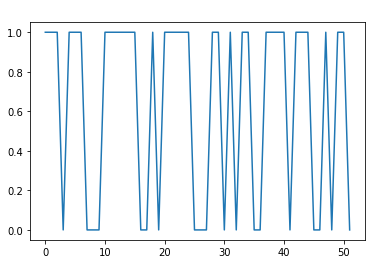

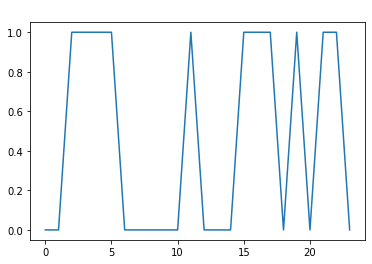

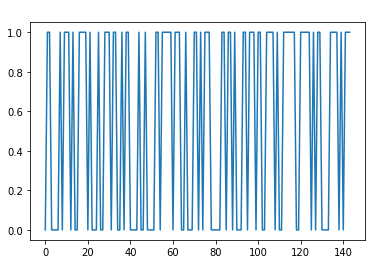

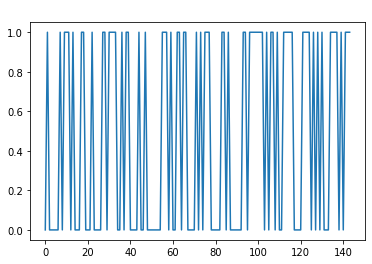

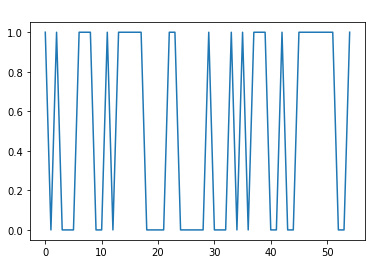

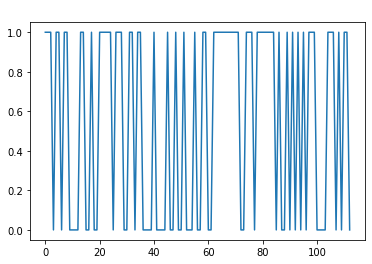

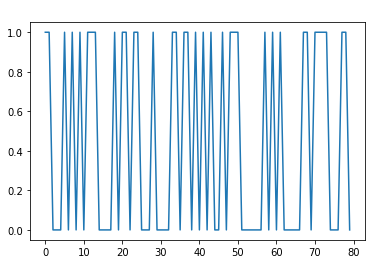

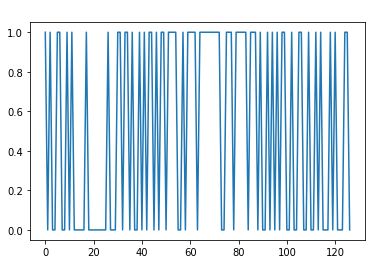

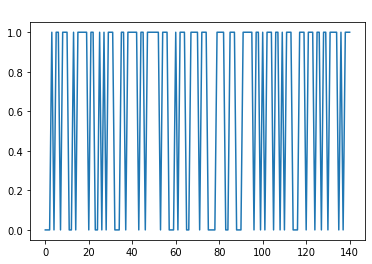

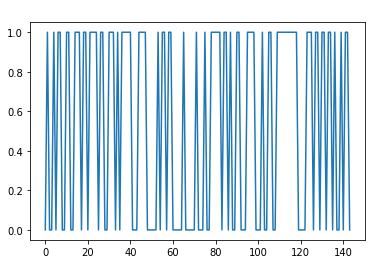

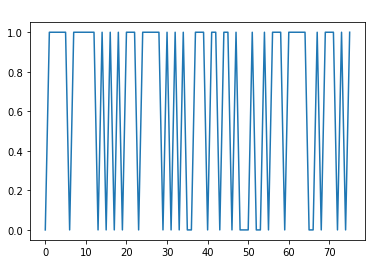

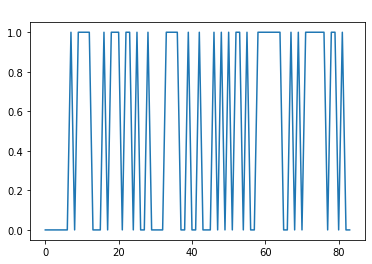

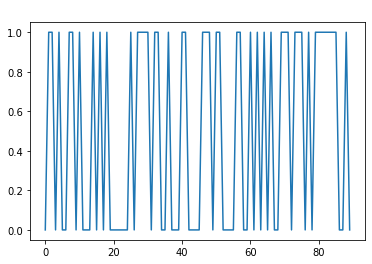

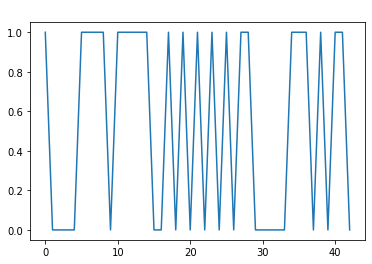

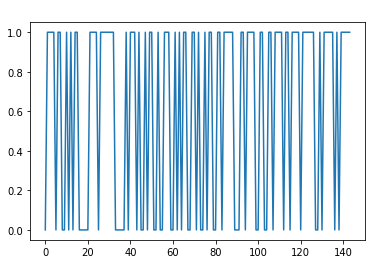

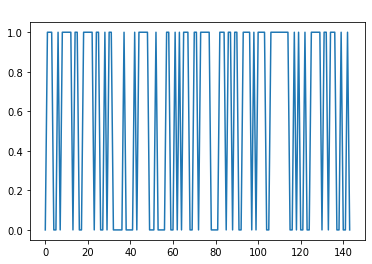

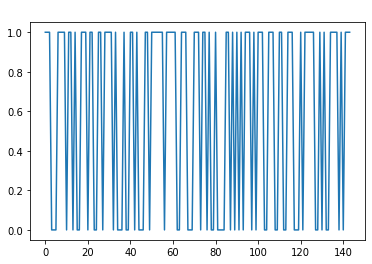

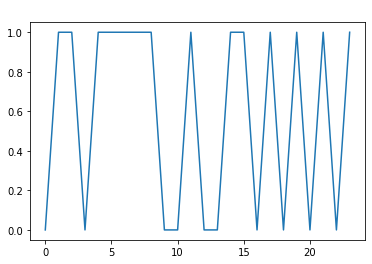

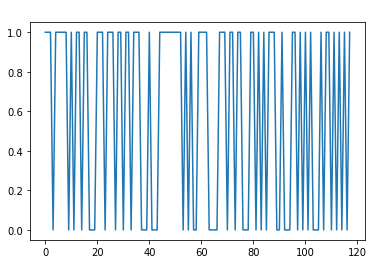

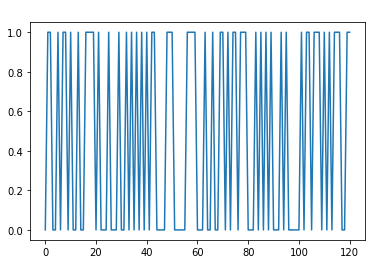

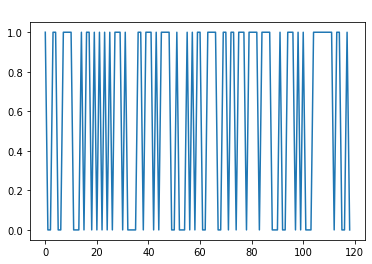

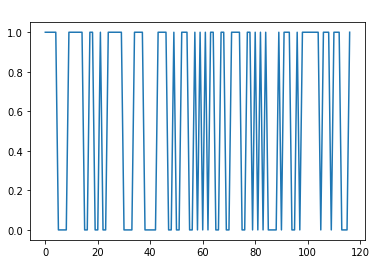

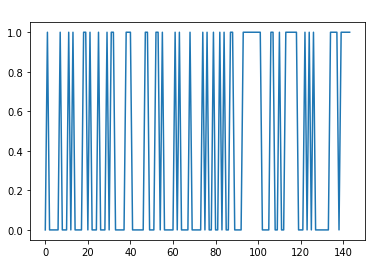

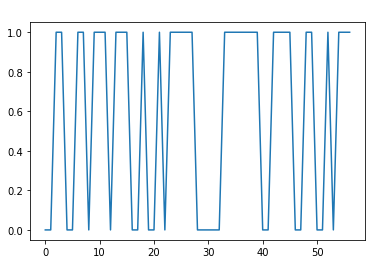

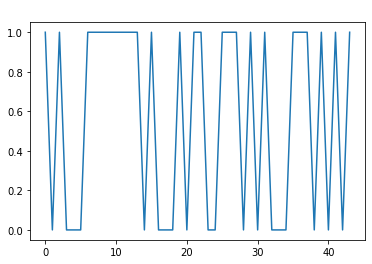

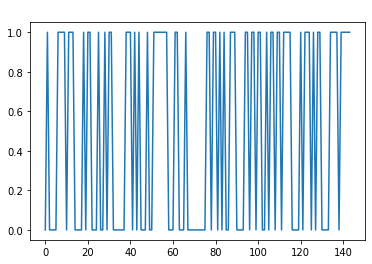

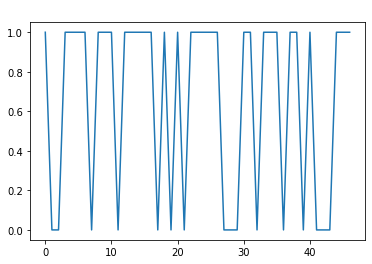

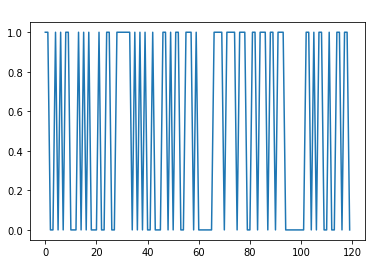

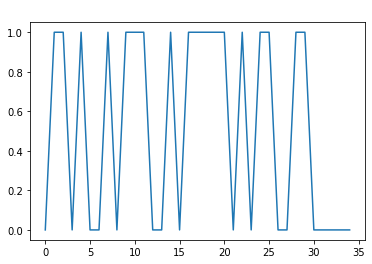

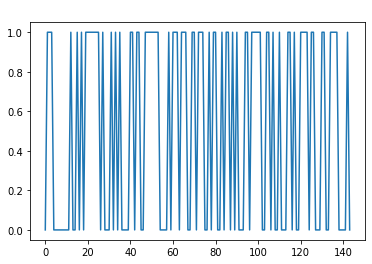

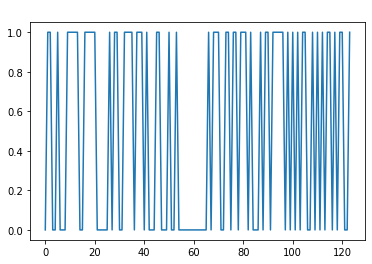

In [11]:
for i in range(len(all_data)):
    k = list(all_data.keys())
    plt.figure(i)
    plt.plot([x for x in range(len(all_data[k[i]]))], all_data[k[i]]["t0"])
    plt.title(k[i],c="white",loc="left")
    print("Proportion Down " +k[i]+" "+ 
          str(round(len(all_data[k[i]].loc[all_data[k[i]]["t0"] == 0]) / len(all_data[k[i]]),2)))

In [12]:
all_data

{'AAPL':      MMYYYY  t0   t1   PeRatio   PsRatio   PbRatio  MarketCap        EV  \
 0    091985   1  1.0  0.214636  0.097151  0.100243   0.000000  0.000000   
 1    121985   1  1.0  0.264110  0.179027  0.179915   0.042950  0.025913   
 2    031986   1  0.0  0.265869  0.243629  0.248882   0.077018  0.068503   
 3    061986   0  0.0  0.214349  0.299191  0.319749   0.109903  0.107142   
 4    091986   0  1.0  0.182735  0.268413  0.232374   0.098957  0.076095   
 ..      ...  ..  ...       ...       ...       ...        ...       ...   
 139  062020   1  0.0  0.374409  0.859993  0.816235   0.951981  0.951465   
 140  092020   0  1.0  0.431288  0.946917  0.921847   0.981594  0.980421   
 141  122020   1  1.0  0.470115  1.000000  1.000000   0.997973  0.996379   
 142  032021   1  1.0  0.413604  0.929659  0.964141   0.986243  0.985867   
 143  062021   1  1.0  0.393944  0.931150  0.985773   1.000000  1.000000   
 
      EVtoEBITDA         Z         Y  
 0      0.000000 -0.393132 -0.742865  


In [13]:
len(all_data)

81

In [34]:
npdf = pd.DataFrame()
tk = []
my = []
t0 = []
t1 = []
y = []
z = []
for x in all_data.keys():
    tk.extend([x for y in range(len(all_data[x]))])
    my.extend([x for x in all_data[x]["MMYYYY"]])
    t0.extend([x for x in all_data[x]["t0"]])
    t1.extend([x for x in all_data[x]["t1"]])
    z.extend([x for x in all_data[x]["Z"]])
    y.extend([x for x in all_data[x]["MarketCap"]])
npdf["Ticker"] = tk
npdf["MMYYYY"] = my
npdf["t0"] = t0
npdf["t1"] = t1
npdf["Z"] = z
npdf["Y"] = y
npdf.head()

Ticker  MMYYYY  t0   t1         Z         Y
0   AAPL  091985   1  1.0 -0.393132  0.000000
1   AAPL  121985   1  1.0 -0.282056  0.042950
2   AAPL  031986   1  0.0 -0.189234  0.077018
3   AAPL  061986   0  0.0 -0.100322  0.109903
4   AAPL  091986   0  1.0 -0.175723  0.098957

In [35]:
np.random.seed(20)
test_comps = np.random.choice(list(all_data.keys()),1, replace = False)
test = npdf.iloc[np.where(npdf["Ticker"] == test_comps[0])]
train = npdf.iloc[np.where(npdf["Ticker"] != test_comps[0])]
train.reset_index(drop = True,inplace = True)
test.reset_index(drop = True,inplace = True)
test_comps[0]

'NTES'

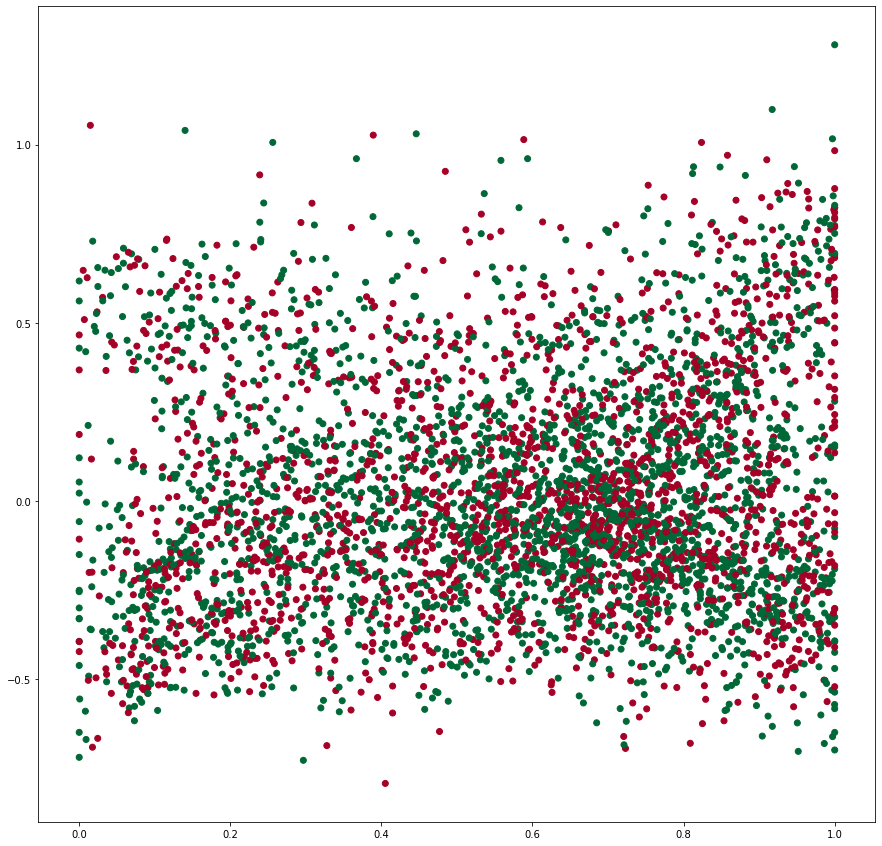

In [36]:
npdfu = train.loc[npdf["t0"] == 1]
f = plt.figure()
f.set_figwidth(15)
f.set_figheight(15)
plt.scatter(npdfu["Y"],npdfu["Z"], c = npdfu["t1"],cmap = "RdYlGn")
plt.show()

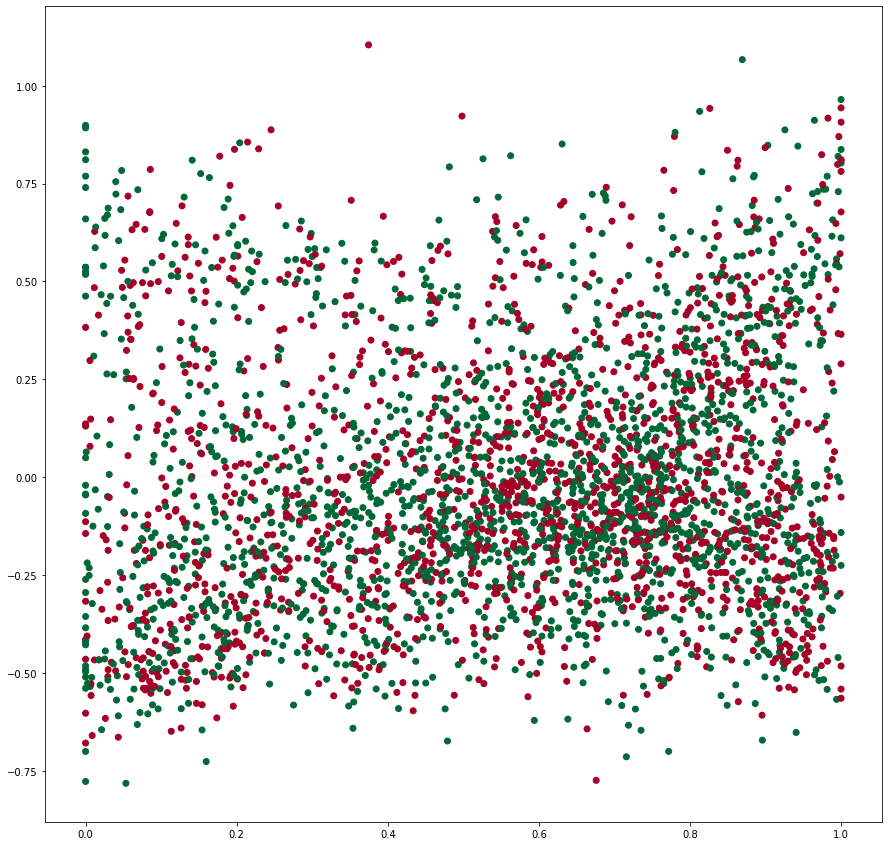

In [37]:
npdfd = train.loc[npdf["t0"] == 0]
f = plt.figure()
f.set_figwidth(15)
f.set_figheight(15)
plt.scatter(npdfd["Y"],npdfd["Z"], c = npdfd["t1"],cmap = "RdYlGn")
plt.show()

In [38]:
len(npdfd), len(npdfu)

(3668, 4618)

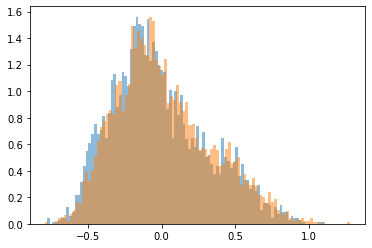

In [39]:
plt.hist(npdfd["Z"],bins=100,density = True,alpha = 0.5)
plt.hist(npdfu["Z"],bins=100,density = True,alpha=0.5)
plt.show()

In [40]:
npdfd["Z"].describe()

count    3668.000000
mean       -0.017664
std         0.325055
min        -0.781901
25%        -0.251972
50%        -0.067262
75%         0.185315
max         1.104298
Name: Z, dtype: float64

In [41]:
npdfu["Z"].describe()

count    4618.000000
mean        0.014030
std         0.324698
min        -0.791716
25%        -0.215151
50%        -0.037994
75%         0.213319
max         1.280193
Name: Z, dtype: float64

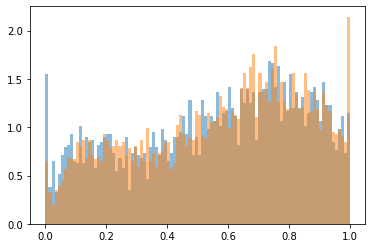

In [43]:
plt.hist(npdfd["Y"],bins=100,density = True,alpha = 0.5)
plt.hist(npdfu["Y"],bins=100,density = True,alpha=0.5)
plt.show()

In [45]:
npdfd["Y"].describe()

count    3668.000000
mean        0.556564
std         0.278361
min         0.000000
25%         0.337289
50%         0.598304
75%         0.786734
max         1.000000
Name: Y, dtype: float64

In [46]:
npdfu["Y"].describe()

count    4618.000000
mean        0.575424
std         0.270495
min         0.000000
25%         0.359402
50%         0.620116
75%         0.797154
max         1.000000
Name: Y, dtype: float64

In [44]:
corrs = pd.DataFrame(columns=returns.keys(),index=returns.keys())
for a in returns.keys():
    for b in returns.keys():
        corrs[a][b] = round(st.pearsonr(returns[a][:min(len(returns[a]),len(returns[b]))],returns[b][:min(len(returns[a]),len(returns[b]))])[0],2)
        if abs(corrs[a][b]) > 0.5 and a != b and a != 'CRWD' and b != 'CRWD':
            print(corrs[a][b],a,b)

0.68 ADI AMAT
0.51 ADI AMD
0.69 ADI KLAC
0.55 ADI LRCX
0.55 ADI PCAR
0.68 ADI TXN
0.52 ADP PAYX
0.62 AEP EXC
0.65 AEP XEL
0.68 AMAT ADI
0.56 AMAT AMD
0.65 AMAT INTC
0.77 AMAT KLAC
0.75 AMAT LRCX
0.65 AMAT MU
0.54 AMAT TEAM
0.7 AMAT TXN
0.51 AMD ADI
0.56 AMD AMAT
0.52 AMD KLAC
0.53 ASML DLTR
0.58 CSX PCAR
0.53 CSX TEAM
0.53 CTAS PAYX
0.55 CTAS PCAR
0.53 CTAS PEP
0.53 DLTR ASML
0.62 EXC AEP
1.0 GOOG GOOGL
1.0 GOOGL GOOG
0.57 HON PCAR
0.53 IDXX NXPI
0.65 INTC AMAT
0.59 INTC KLAC
0.54 INTC LRCX
0.58 INTC TXN
0.69 KLAC ADI
0.77 KLAC AMAT
0.52 KLAC AMD
0.59 KLAC INTC
0.69 KLAC LRCX
0.54 KLAC MU
0.62 KLAC TXN
0.55 LRCX ADI
0.75 LRCX AMAT
0.54 LRCX INTC
0.69 LRCX KLAC
0.52 LRCX MU
0.52 LRCX TXN
0.56 MELI NXPI
0.51 MTCH SIRI
0.65 MU AMAT
0.54 MU KLAC
0.52 MU LRCX
0.53 MU TXN
0.53 NXPI IDXX
0.56 NXPI MELI
0.52 PAYX ADP
0.53 PAYX CTAS
0.55 PCAR ADI
0.58 PCAR CSX
0.55 PCAR CTAS
0.57 PCAR HON
0.7 PCAR TEAM
0.53 PEP CTAS
0.51 SIRI MTCH
0.57 SWKS TEAM
0.54 TEAM AMAT
0.53 TEAM CSX
0.7 TEAM PCAR
0.57 T

In [26]:
corrs

AAPL  ADBE   ADI   ADP  ADSK   AEP  ALGN  AMAT   AMD  AMGN  ...  TEAM  \
AAPL     1 -0.03  0.33  0.25 -0.17  0.02     0  0.36  0.35  0.23  ...  0.29   
ADBE -0.03     1  0.06  0.04 -0.08 -0.11  0.03  0.16 -0.03 -0.04  ...  0.23   
ADI   0.33  0.06     1  0.45 -0.07  0.08 -0.01  0.68  0.51  0.04  ...  0.48   
ADP   0.25  0.04  0.45     1  -0.1  0.37   0.2  0.39  0.21  0.26  ...  0.46   
ADSK -0.17 -0.08 -0.07  -0.1     1 -0.02  0.03 -0.26 -0.14 -0.15  ...  -0.4   
...    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
VRSN  0.17   0.1  0.16  0.29 -0.01  0.17  0.31  0.13  0.02  0.23  ...  0.34   
VRTX  0.08  0.16  0.04  0.13 -0.13 -0.03  0.09  0.15  0.06  0.09  ...  0.43   
WDAY  0.36  -0.1  0.07  0.13 -0.08  0.02  0.03   0.1  0.17  0.34  ...  0.23   
XEL   0.13  -0.1  0.24  0.37 -0.02  0.65  0.04  0.09  0.05 -0.01  ...  0.03   
XLNX -0.04 -0.04  0.06   0.1 -0.03  0.03  -0.1  0.05 -0.08     0  ...  0.44   

      TMUS  TSLA   TXN  VRSK  VRSN  VRTX  WDAY   XEL  XLNX  
AAPL -0.05  0.06  0.29  0.15  0.17  0.08  0.36  0.13 -0.04  
ADBE -0.17 -0.28  0.11  0.37   0.1  0.16  -0.1  -0.1 -0.04  
ADI  -0.16 -0.12  0.68  0.13  0.16  0.04  0.07  0.24  0.06  
ADP  -0.26 -0.23  0.29  0.14  0.29  0.13  0.13  0.37   0.1  
ADSK  0.08  0.14 -0.21 -0.33 -0.01 -0.13 -0.08 -0.02 -0.03  
...    ...   ...   ...   ...   ...   ...   ...   ...   ...  
VRSN -0.02 -0.31  0.13  0.26     1  0.02 -0.06   0.1     0  
VRTX  0.03 -0.21 -0.08  0.09  0.02     1 -0.01  0.03  0.03  
WDAY  0.07 -0.02  0.17 -0.09 -0.06 -0.01     1  0.03  0.01  
XEL  -0.13  0.23  0.02 -0.02   0.1  0.03  0.03     1  0.02  
XLNX -0.06 -0.11    -0 -0.04     0  0.03  0.01  0.02     1  

[93 rows x 93 columns]

In [47]:
for x in all_data.keys():
    print('-'*30)
    print(x)
    print(round(all_data[x][['Z','Y']].describe(),5))
    print('-'*30)

------------------------------
AAPL
               Z          Y
count  144.00000  144.00000
mean    -0.00000    0.00000
std      0.30954    0.43117
min     -0.52173   -0.74286
25%     -0.24382   -0.37156
50%      0.04108   -0.20686
75%      0.22802    0.44995
max      0.85637    0.78726
------------------------------
------------------------------
ADBE
               Z          Y
count  139.00000  139.00000
mean     0.00000   -0.00000
std      0.30776    0.36876
min     -0.62120   -0.73181
25%     -0.27341   -0.24443
50%     -0.00280   -0.04098
75%      0.18748    0.30601
max      0.88735    0.80347
------------------------------
------------------------------
ADI
               Z          Y
count  143.00000  143.00000
mean     0.00000   -0.00000
std      0.23030    0.41091
min     -0.50963   -0.63430
25%     -0.12505   -0.27867
50%      0.01502   -0.10991
75%      0.11709    0.32858
max      0.83516    0.81825
------------------------------
------------------------------
ADP
         

               Z          Y
count  144.00000  144.00000
mean    -0.00000    0.00000
std      0.27128    0.39361
min     -0.53573   -0.65854
25%     -0.13442   -0.27602
50%     -0.02227   -0.16539
75%      0.13439    0.28323
max      0.66979    0.78189
------------------------------
------------------------------
LRCX
               Z          Y
count  144.00000  144.00000
mean     0.00000   -0.00000
std      0.27648    0.36064
min     -0.61618   -0.66948
25%     -0.18183   -0.21653
50%     -0.00079   -0.10537
75%      0.14752    0.15452
max      0.80972    0.91243
------------------------------
------------------------------
LULU
              Z         Y
count  55.00000  55.00000
mean    0.00000   0.00000
std     0.31294   0.35487
min    -0.79172  -0.62802
25%    -0.23579  -0.18048
50%     0.05051  -0.05653
75%     0.18918   0.12216
max     0.89229   0.98726
------------------------------
------------------------------
MCHP
               Z          Y
count  113.00000  113.00000
mean 

               Z          Y
count  144.00000  144.00000
mean     0.00000   -0.00000
std      0.29236    0.48369
min     -0.72689   -0.77196
25%     -0.17183   -0.35739
50%     -0.07344   -0.13806
75%      0.12183    0.27568
max      0.80948    0.92967
------------------------------
------------------------------
XLNX
               Z          Y
count  124.00000  124.00000
mean    -0.00000   -0.00000
std      0.30832    0.34319
min     -0.50423   -0.56932
25%     -0.23852   -0.22399
50%     -0.06366   -0.07586
75%      0.15090    0.15694
max      0.89223    0.92224
------------------------------


In [28]:
per=[]
for x in all_data.keys():
    print('-'*7)
    print(x +":",round(all_data[x][['t0']].count(),0)[0])
    per.append(round(all_data[x][['t0']].count(),0)[0])

-------
AAPL: 144
-------
ADBE: 139
-------
ADI: 143
-------
ADP: 144
-------
ADSK: 107
-------
AEP: 144
-------
ALGN: 82
-------
AMAT: 143
-------
AMD: 144
-------
AMGN: 144
-------
AMZN: 96
-------
ANSS: 100
-------
ASML: 105
-------
ATVI: 107
-------
AVGO: 46
-------
BIDU: 61
-------
BIIB: 69
-------
BKNG: 89
-------
BMRN: 88
-------
CDNS: 136
-------
CDW: 32
-------
CERN: 138
-------
CHKP: 100
-------
CHTR: 46
-------
CMCSA: 103
-------
COST: 140
-------
CPRT: 108
-------
CSCO: 125
-------
CSX: 144
-------
CTAS: 144
-------
CTSH: 92
-------
DLTR: 104
-------
DXCM: 65
-------
EA: 127
-------
EBAY: 91
-------
EXC: 123
-------
FAST: 135
-------
FB: 36
-------
FISV: 139
-------
GILD: 117
-------
GOOG: 30
-------
GOOGL: 67
-------
HON: 144
-------
IDXX: 120
-------
ILMN: 84
-------
INCY: 110
-------
INTC: 144
-------
INTU: 112
-------
ISRG: 84
-------
JD: 28
-------
KDP: 52
-------
KHC: 24
-------
KLAC: 144
-------
LRCX: 144
-------
LULU: 55
-------
MCHP: 113
-------
MDLZ: 80
-------
MN

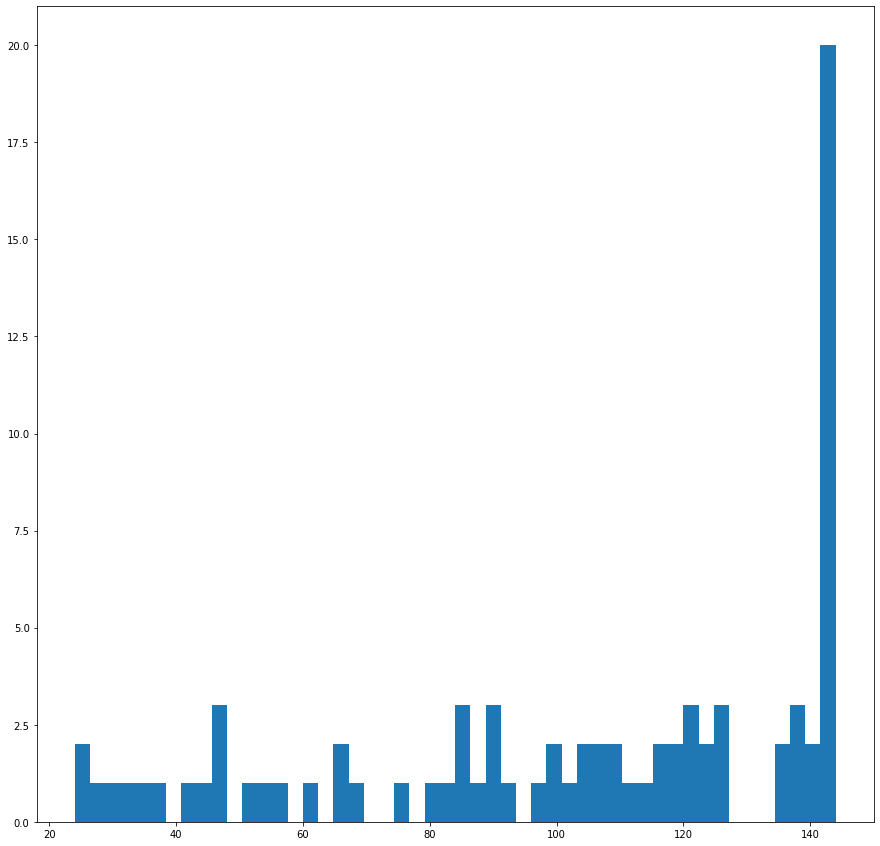

count     81.000000
mean     103.333333
std       38.312204
min       24.000000
10%       44.000000
20%       65.000000
30%       84.000000
40%      100.000000
50%      112.000000
60%      121.000000
70%      138.000000
80%      144.000000
90%      144.000000
max      144.000000
dtype: float64

In [29]:
f = plt.figure()
f.set_figwidth(15)
f.set_figheight(15)
plt.hist(per,bins=50)
plt.show()
pd.Series(per).describe(percentiles = [0.1+0.1*i for i in range(9)])

In [49]:
y = []
z = []
for x in all_data.keys():
    y.append(all_data[x]["Y"].mean())
    z.append(all_data[x]["Z"].mean())

(array([ 3., 14., 13., 17., 14., 10.,  5.,  4.,  0.,  1.]),
 array([-1.64592504e-16, -1.16567167e-16, -6.85418298e-17, -2.05164925e-17,
         2.75088448e-17,  7.55341820e-17,  1.23559519e-16,  1.71584857e-16,
         2.19610194e-16,  2.67635531e-16,  3.15660868e-16]),
 <a list of 10 Patch objects>)

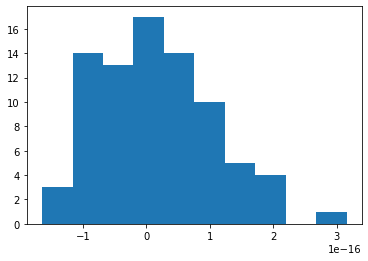

In [50]:
plt.hist(y)

(array([ 2.,  1.,  6.,  9., 13., 16., 15., 10.,  6.,  3.]),
 array([-1.78772133e-16, -1.45937748e-16, -1.13103364e-16, -8.02689790e-17,
        -4.74345944e-17, -1.46002098e-17,  1.82341747e-17,  5.10685593e-17,
         8.39029439e-17,  1.16737328e-16,  1.49571713e-16]),
 <a list of 10 Patch objects>)

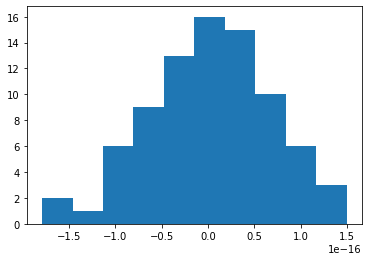

In [51]:
plt.hist(z)